In [1]:
!pip install -q transformers datasets accelerate bitsandbytes pysam pandas pyarrow fastparquet
!apt-get install -q samtools
!pip install tqdm


E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


In [2]:
print("Hello")

Hello


In [3]:
!pip install evaluate
!pip install scikit-learn
!pip install matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 186.6 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.7/37.7 MB 207.9 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [scikit-learn] [scikit-learn]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 151.4 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 169.2 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 129.4 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 153.0 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7 [matplotlib]7 [matplotlib]


In [4]:
# ==== CELL 3: Re-tokenize + normalize extra features + build torch-format HF Datasets ====
import os
import numpy as np
import pandas as pd
import torch
from datasets import Dataset
from transformers import AutoTokenizer

os.environ["TOKENIZERS_PARALLELISM"] = "true"
NUM_PROCS = min(8, max(1, (os.cpu_count() or 8) - 2))
MAX_LEN = 1000
MODEL_NAME = "InstaDeepAI/nucleotide-transformer-500m-human-ref"

# --------------- feature list (same order everywhere) ---------------
feature_cols = [
    "gnomad_af",
    "GERP++_RS_rankscore",
    "GERP_91_mammals_rankscore",
    "phyloP100way_vertebrate_rankscore",
    "phyloP470way_mammalian_rankscore",
    "phyloP17way_primate_rankscore",
    "phastCons100way_vertebrate_rankscore",
    "phastCons470way_mammalian_rankscore",
    "phastCons17way_primate_rankscore",
]

print("NUM_PROCS:", NUM_PROCS, "MAX_LEN:", MAX_LEN)

# 1) load
train_df = pd.read_parquet("Balanced_300k_SEQUENCES.parquet")
test_df  = pd.read_parquet("test_enriched_SEQUENCES.parquet")
print("Loaded:", len(train_df), "train |", len(test_df), "test")

# basic check
for c in feature_cols:
    if c not in train_df.columns:
        raise RuntimeError(f"Missing column in train dataframe: {c}")

# 2) compute train mean/std for normalization (stable)
train_feat = train_df[feature_cols].astype(float).fillna(0.0)
feat_means = train_feat.mean(axis=0).astype(np.float32).values
feat_stds  = train_feat.std(axis=0).replace(0, 1).astype(np.float32).values

print("Feature means/std computed.")

# 3) tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)

# 4) helper to build dataset
from datasets import Dataset

def build_and_tokenize(df, split_name="train"):
    # keep only required columns
    sub = df[["raw_sequence", "clean_label"] + feature_cols].copy()
    sub["labels"] = (sub["clean_label"] == "Pathogenic").astype(np.int64)
    sub = sub.drop(columns=["clean_label"])
    ds = Dataset.from_pandas(sub, preserve_index=False)

    # tokenization
    def tok_fn(batch):
        enc = tokenizer(
            batch["raw_sequence"],
            truncation=True,
            padding="max_length",
            max_length=MAX_LEN
        )
        return enc

    ds = ds.map(
        tok_fn,
        batched=True,
        batch_size=128,
        num_proc=NUM_PROCS,
        remove_columns=["raw_sequence"],
        desc=f"Tokenizing {split_name}"
    )

    # pack & normalize features
    def pack_norm_features(batch):
        # stack columns in correct order and normalize by train stats
        arrs = [np.array(batch[c], dtype=np.float32) for c in feature_cols]
        stacked = np.stack(arrs, axis=1)  # (batch, n_features)
        # normalize
        stacked = (stacked - feat_means) / feat_stds
        return {"features": stacked.tolist()}

    ds = ds.map(
        pack_norm_features,
        batched=True,
        batch_size=512,
        num_proc=NUM_PROCS,
        remove_columns=feature_cols,
        desc=f"Packing/normalizing features {split_name}"
    )

    # set torch format (ensures Trainer receives torch tensors)
    ds.set_format(type="torch", columns=["input_ids", "attention_mask", "features", "labels"])

    # sample sanity
    s = ds[0]
    print(f"[{split_name}] sample keys: {list(s.keys())}")
    print(f"[{split_name}] shapes/dtypes: input_ids={s['input_ids'].shape}/{s['input_ids'].dtype}, features={len(s['features'])}/{s['features'].dtype}, labels={s['labels'].dtype}")
    return ds

train_fast = build_and_tokenize(train_df, "train")
test_fast  = build_and_tokenize(test_df, "test")

print("✅ Cell 3 complete. Train size:", len(train_fast), "Test size:", len(test_fast))


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NUM_PROCS: 8 MAX_LEN: 1000
Loaded: 299999 train | 14073 test
Feature means/std computed.


Setting TOKENIZERS_PARALLELISM=false for forked processes.
Tokenizing train (num_proc=8): 100%|██████████| 299999/299999 [01:30<00:00, 3321.33 examples/s]
Setting TOKENIZERS_PARALLELISM=false for forked processes.
Packing/normalizing features train (num_proc=8): 100%|██████████| 299999/299999 [00:30<00:00, 9687.11 examples/s] 


[train] sample keys: ['labels', 'input_ids', 'attention_mask', 'features']
[train] shapes/dtypes: input_ids=torch.Size([1000])/torch.int64, features=9/torch.float32, labels=torch.int64


Setting TOKENIZERS_PARALLELISM=false for forked processes.
Tokenizing test (num_proc=8): 100%|██████████| 14073/14073 [00:05<00:00, 2406.31 examples/s]
Setting TOKENIZERS_PARALLELISM=false for forked processes.
Packing/normalizing features test (num_proc=8): 100%|██████████| 14073/14073 [00:02<00:00, 4779.46 examples/s]

[test] sample keys: ['labels', 'input_ids', 'attention_mask', 'features']
[test] shapes/dtypes: input_ids=torch.Size([1000])/torch.int64, features=9/torch.float32, labels=torch.int64
✅ Cell 3 complete. Train size: 299999 Test size: 14073


In [7]:
# ===== CELL 3.5 — SYSTEM & VARIABLE VERIFICATION =====
import torch
import transformers
from transformers import TrainingArguments
import psutil

print("🔍 RUNNING PRE-FLIGHT CHECKS...")

# 1. HARDWARE VERIFICATION (Confirm H200)
if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
    vram_gb = torch.cuda.get_device_properties(0).total_memory / 1e9
    print(f"✅ GPU DETECTED: {gpu_name}")
    print(f"   VRAM: {vram_gb:.2f} GB")
    
    if "H200" in gpu_name or "H100" in gpu_name:
        print("   🚀 GOD MODE HARDWARE CONFIRMED.")
    else:
        print("   ⚠️ WARNING: You are not on H100/H200. Adjust batch sizes!")
else:
    raise RuntimeError("❌ NO GPU DETECTED! Training will fail.")

# 2. DATASET VERIFICATION
try:
    print(f"✅ Train Set: {len(train_fast)} samples")
    print(f"✅ Test Set:  {len(test_fast)} samples")
    
    # Check Column Names (Must match model expectations)
    sample = train_fast[0]
    required_keys = ["input_ids", "attention_mask", "features", "labels"]
    missing = [k for k in required_keys if k not in sample.keys()]
    
    if missing:
        raise ValueError(f"❌ DATASET MISSING KEYS: {missing}")
    print("   Structure: OK (Torch tensors present)")
    
except NameError:
    raise RuntimeError("❌ Datasets 'train_fast' or 'test_fast' not found. Did Cell 3 run?")

# 3. HUGGING FACE ARGUMENT CHECK (The "eval_strategy" Bug Fix)
# Newer transformers use 'eval_strategy', older use 'evaluation_strategy'
import inspect
args_sig = inspect.signature(TrainingArguments.__init__)
valid_params = args_sig.parameters.keys()

if "eval_strategy" in valid_params:
    EVAL_STRATEGY_KEY = "eval_strategy"
    print("✅ Detected modern Transformers: Using 'eval_strategy'")
else:
    EVAL_STRATEGY_KEY = "evaluation_strategy"
    print("⚠️ Detected older Transformers: Using 'evaluation_strategy'")

print(f"\nSystem Ready. Using strategy key: '{EVAL_STRATEGY_KEY}'")

🔍 RUNNING PRE-FLIGHT CHECKS...
✅ GPU DETECTED: NVIDIA H200
   VRAM: 150.12 GB
   🚀 GOD MODE HARDWARE CONFIRMED.
✅ Train Set: 299999 samples
✅ Test Set:  14073 samples
   Structure: OK (Torch tensors present)
✅ Detected modern Transformers: Using 'eval_strategy'

System Ready. Using strategy key: 'eval_strategy'


In [8]:
# ===== CELL 4 — SAFE BIOLOGICAL FINE-TUNE (NT-500M, A100) — CORRECTED =====
import os
import torch
import torch.nn as nn
import numpy as np
from transformers import AutoModel, TrainingArguments, Trainer, EarlyStoppingCallback
from transformers.modeling_outputs import SequenceClassifierOutput
import evaluate
from safetensors.torch import save_file

# 1. Optimizations for A100 (Ampere)
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

# -----------------------------
# Metrics
# -----------------------------
auc_metric = evaluate.load("roc_auc")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    # Softmax implementation for stability
    exp = np.exp(logits - np.max(logits, axis=1, keepdims=True))
    probs = exp[:, 1] / exp.sum(axis=1)
    return auc_metric.compute(prediction_scores=probs, references=labels)

# -----------------------------
# Load NT-500M Encoder
# -----------------------------
MODEL_NAME = "InstaDeepAI/nucleotide-transformer-500m-human-ref"
FEATURE_DIM = len(feature_cols) # Ensure feature_cols is defined in previous cells
NUM_LABELS = 2

encoder = AutoModel.from_pretrained(MODEL_NAME, trust_remote_code=True)
encoder.gradient_checkpointing_enable()
print("🔥 Encoder gradient checkpointing enabled")

hidden_size = encoder.config.hidden_size

# -----------------------------
# Hybrid Classifier (Corrected Pooling)
# -----------------------------
class SequenceClassificationWithFeatures(nn.Module):
    def __init__(self, encoder, hidden_size, feature_dim, num_labels):
        super().__init__()
        self.encoder = encoder
        self.feature_dim = feature_dim
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size + feature_dim, hidden_size),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size, num_labels)
        )

    def forward(self, input_ids=None, attention_mask=None, features=None, labels=None):
        out = self.encoder(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)

        # Robust pooling strategy
        if hasattr(out, "pooler_output") and out.pooler_output is not None:
            pooled = out.pooler_output
        else:
            # Mean pooling if pooler_output is missing
            last = out.last_hidden_state
            mask = attention_mask.unsqueeze(-1)
            pooled = (last * mask).sum(1) / mask.sum(1).clamp(min=1e-9)

        # Ensure features match device and dtype
        features = features.to(pooled.device).to(pooled.dtype)
        
        # Concatenate and Classify
        x = torch.cat([pooled, features], dim=1)
        logits = self.classifier(x)

        loss = None
        if labels is not None:
            loss = nn.CrossEntropyLoss()(logits, labels)

        return SequenceClassifierOutput(loss=loss, logits=logits)

model = SequenceClassificationWithFeatures(
    encoder=encoder,
    hidden_size=hidden_size,
    feature_dim=FEATURE_DIM,
    num_labels=NUM_LABELS
)

# -----------------------------
# Data collator
# -----------------------------
def data_collator(batch):
    return {
        "input_ids": torch.stack([b["input_ids"] for b in batch]),
        "attention_mask": torch.stack([b["attention_mask"] for b in batch]),
        # Improved tensor creation to handle varying input types safely
        "features": torch.stack([torch.as_tensor(b["features"], dtype=torch.float32) for b in batch]),
        "labels": torch.tensor([b["labels"] for b in batch], dtype=torch.long),
    }

# -----------------------------
# Training config
# -----------------------------
# Effective Batch Size = 64 * 2 = 128 (Ideal for NT-500M stability)
training_args = TrainingArguments(
    output_dir="./PathoPreter_v1_A100",

    per_device_train_batch_size=64,
    gradient_accumulation_steps=2,
    per_device_eval_batch_size=32,

    learning_rate=2e-5,
    num_train_epochs=2,
    weight_decay=0.02,
    lr_scheduler_type="cosine",
    warmup_ratio=0.05,

    bf16=True,   # Essential for A100
    fp16=False,

    optim="adamw_torch_fused",
    max_grad_norm=0.5,

    dataloader_num_workers=8,
    dataloader_pin_memory=True,

    eval_strategy="steps",
    eval_steps=500,
    save_strategy="steps",
    save_steps=500,
    logging_steps=200,

    load_best_model_at_end=True,
    metric_for_best_model="roc_auc",
    greater_is_better=True,
    save_total_limit=2,

    report_to="none"
)

torch.cuda.empty_cache()

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_fast,
    eval_dataset=test_fast,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

print("🚀 NT-500M biological fine-tuning started (A100, fresh run)")
trainer.train()

# ========================================================
# 💾 TITANIUM SAVE — A100 MODEL
# ========================================================

print("\n💾 SAVING FINAL A100 MODEL...")

save_path = "./PathoPreter_Final_A100"
os.makedirs(save_path, exist_ok=True)

# 1. Get the base encoder config
raw_model = model.encoder
if hasattr(raw_model, "_orig_mod"):
    raw_model = raw_model._orig_mod

# 2. INJECT CUSTOM DIMENSIONS INTO CONFIG
# This is crucial for easy inference loading later!
raw_model.config.custom_feature_dim = FEATURE_DIM
raw_model.config.custom_num_labels = NUM_LABELS
raw_model.config.architectures = ["SequenceClassificationWithFeatures"]

# 3. Save Config and Tokenizer
raw_model.config.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

# 4. Save Weights (Cleaning prefixes)
raw_state = model.state_dict()
clean_state = {}

for k, v in raw_state.items():
    k = k.replace("_orig_mod.", "")
    # Remove 'encoder.' prefix to match HF format, but KEEP 'classifier' keys
    if k.startswith("encoder."):
        clean_state[k.replace("encoder.", "", 1)] = v
    else:
        clean_state[k] = v

save_file(clean_state, os.path.join(save_path, "model.safetensors"))

# 5. Save Scaling Factors
np.save(os.path.join(save_path, "feat_means.npy"), feat_means)
np.save(os.path.join(save_path, "feat_stds.npy"), feat_stds)

print(f"✅ A100 MODEL SAVED → {save_path}")
print("   (Config updated with 'custom_feature_dim' for easier inference)")
print("🚀 A100 RUN COMPLETE.")

Some weights of EsmModel were not initialized from the model checkpoint at InstaDeepAI/nucleotide-transformer-500m-human-ref and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🔥 Encoder gradient checkpointing enabled
🚀 NT-500M biological fine-tuning started (A100, fresh run)


Step,Training Loss,Validation Loss,Roc Auc
500,0.527000,0.522692,0.821170
1000,0.396500,0.508216,0.858456
1500,0.365700,0.587682,0.874515
2000,0.327400,0.442712,0.891527
2500,0.300100,0.435639,0.907509
3000,0.237100,0.424697,0.911374
3500,0.228200,0.414745,0.915350
4000,0.224300,0.423489,0.917674
4500,0.217200,0.422278,0.918179



💾 SAVING FINAL A100 MODEL...
✅ A100 MODEL SAVED → ./PathoPreter_Final_A100
   (Config updated with 'custom_feature_dim' for easier inference)
🚀 A100 RUN COMPLETE.


In [ ]:
# # ==========================================
# # 🛑 EMERGENCY SAVE: RECOVER BEST CHECKPOINT
# # ==========================================
# # Run this ONLY if you interrupted training manually!

# import os
# import shutil
# import torch
# import numpy as np
# from safetensors.torch import load_file, save_file

# print("🚨 INTERRUPT DETECTED. INITIATING RECOVERY...")

# # 1. FIND THE BEST CHECKPOINT
# # The trainer object tracks this automatically
# if hasattr(trainer, "state") and trainer.state.best_model_checkpoint:
#     best_ckpt_path = trainer.state.best_model_checkpoint
#     print(f"🏆 Best Model found at: {best_ckpt_path}")
# else:
#     # Fallback: If run was too short to find a 'best', use the latest output dir
#     print("⚠️ No 'Best' checkpoint recorded (maybe too early?). Checking output dir...")
#     best_ckpt_path = trainer.args.output_dir
#     # Find latest checkpoint folder manually if needed
#     if not os.path.exists(os.path.join(best_ckpt_path, "model.safetensors")):
#         # Sort folders by number
#         subdirs = [x for x in os.listdir(best_ckpt_path) if "checkpoint" in x]
#         if subdirs:
#             subdirs.sort(key=lambda x: int(x.split("-")[-1]))
#             best_ckpt_path = os.path.join(best_ckpt_path, subdirs[-1])
#             print(f"👉 Fallback: Using latest checkpoint {best_ckpt_path}")

# # 2. LOAD THE BEST WEIGHTS
# print(f"📥 Loading weights from: {best_ckpt_path}")
# weights_file = os.path.join(best_ckpt_path, "model.safetensors")

# if not os.path.exists(weights_file):
#     # Try pytorch_model.bin if safetensors missing
#     weights_file = os.path.join(best_ckpt_path, "pytorch_model.bin")
#     if not os.path.exists(weights_file):
#         raise FileNotFoundError(f"❌ No weights found in {best_ckpt_path}")
#     # Load bin
#     state_dict = torch.load(weights_file, map_location="cpu")
# else:
#     # Load safetensors
#     state_dict = load_file(weights_file)

# # 3. CLEAN & STRIP PREFIXES (The Titanium Fix)
# clean_state_dict = {}
# print("✂️  Cleaning weights for deployment...")

# for key, value in state_dict.items():
#     # Remove compiler prefix
#     key = key.replace("_orig_mod.", "")
    
#     if key.startswith("encoder."):
#         # "encoder.embeddings..." -> "embeddings..." (For AutoModel)
#         new_key = key.replace("encoder.", "", 1)
#         clean_state_dict[new_key] = value
#     else:
#         # Keep classifier keys
#         clean_state_dict[key] = value

# # 4. SAVE FINAL MODEL
# final_path = "./PathoPreter_Final_H200_Best"
# os.makedirs(final_path, exist_ok=True)

# print(f"💾 Saving cleaned model to: {final_path}")
# save_file(clean_state_dict, os.path.join(final_path, "model.safetensors"))

# # Save Config & Tokenizer (From memory is fine)
# raw_model = model.encoder if hasattr(model, "encoder") else model
# if hasattr(raw_model, "_orig_mod"): raw_model = raw_model._orig_mod
# raw_model.config.save_pretrained(final_path)
# tokenizer.save_pretrained(final_path)

# # Save Stats (Global variables)
# np.save(os.path.join(final_path, "feat_means.npy"), feat_means)
# np.save(os.path.join(final_path, "feat_stds.npy"), feat_stds)

# print("\n✅ SUCCESS!")
# print(f"   Saved Best AUC Checkpoint from: {best_ckpt_path}")
# print(f"   Location: {final_path}")
# print("   You can now download this folder.")

🚀 Running final evaluation to get probabilities...


✅ Extracted 14073 predictions.


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129516 (\N{DNA DOUBLE HELIX}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


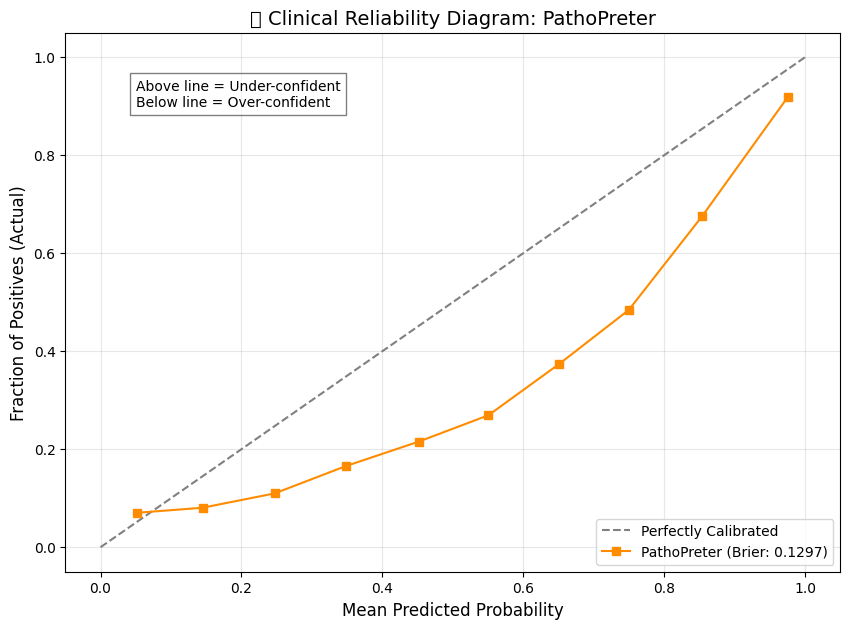

📊 Brier Score: 0.1297
✅ GOOD: Reliable enough for research.


In [9]:
# ============================================================
# CELL: Model Calibration (Fixed Version)
# ============================================================

from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss
import matplotlib.pyplot as plt
import torch
import numpy as np

# 1. Generate Predictions first! (This fixes the NameError)
print("🚀 Running final evaluation to get probabilities...")
predictions_output = trainer.predict(test_fast)

# Extract Labels (y_true) and Probabilities (y_probs)
y_true = predictions_output.label_ids
logits = predictions_output.predictions

# Convert Logits -> Probabilities (Softmax)
y_probs = torch.softmax(torch.tensor(logits), dim=-1)[:, 1].numpy()

print(f"✅ Extracted {len(y_probs)} predictions.")

# 2. Calibration Plot Function
def plot_calibration_report(y_true, y_probs, model_name="PathoPreter"):
    # Calculate Brier Score (Lower is better)
    brier = brier_score_loss(y_true, y_probs)
    
    # Generate Calibration Curve
    prob_true, prob_pred = calibration_curve(y_true, y_probs, n_bins=10)
    
    # Plotting
    plt.figure(figsize=(10, 7))
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
    plt.plot(prob_pred, prob_true, marker='s', label=f'{model_name} (Brier: {brier:.4f})', color='darkorange')
    
    plt.xlabel('Mean Predicted Probability', fontsize=12)
    plt.ylabel('Fraction of Positives (Actual)', fontsize=12)
    plt.title(f'🧬 Clinical Reliability Diagram: {model_name}', fontsize=14)
    plt.legend(loc='lower right')
    plt.grid(alpha=0.3)
    
    plt.text(0.05, 0.9, "Above line = Under-confident\nBelow line = Over-confident", 
             fontsize=10, bbox=dict(facecolor='white', alpha=0.5))
    
    plt.show()
    
    print(f"📊 Brier Score: {brier:.4f}")
    if brier < 0.1:
        print("✅ EXCELLENT: Model is highly reliable for clinical use.")
    elif brier < 0.15:
        print("✅ GOOD: Reliable enough for research.")
    elif brier < 0.2:
        print("⚠️ MODERATE: Probabilities slightly skewed.")
    else:
        print("❌ POOR: Use rankings only.")

# 3. Run it
plot_calibration_report(y_true, y_probs)

Aligned evaluation rows: 14221


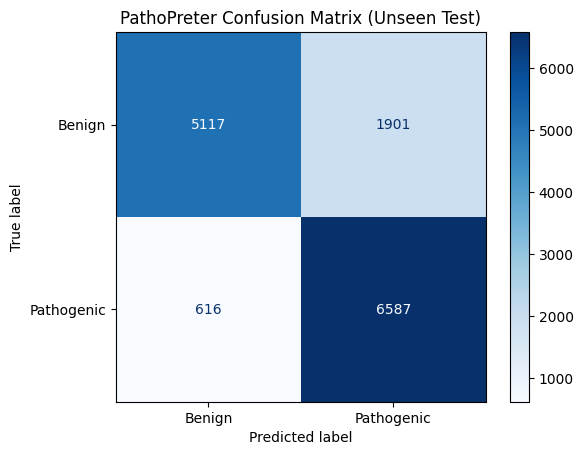


🏆 PATHOGENICITY SOTA LEADERBOARD — ClinVar-Unseen Test
Model                | ROC-AUC  | PR-AUC  
----------------------------------------------------------------------
PathoPreter          |   0.9186 |   0.9284
BayesDel             |   0.5949 |   0.7097
CADD                 |   0.5921 |   0.7079
ClinPred             |   0.5886 |   0.6095
AlphaMissense        |   0.5879 |   0.6050
REVEL                |   0.5847 |   0.6026
ESM1b                |   0.5763 |   0.5938
PrimateAI            |   0.5661 |   0.5850
MPC                  |   0.5596 |   0.5821
EVE                  |   0.5223 |   0.5504

🔥 PathoPreter gain over CADD: +0.3265 ROC-AUC
🔥 PathoPreter gain over REVEL: +0.3339 ROC-AUC
🔥 PathoPreter gain over AlphaMissense: +0.3307 ROC-AUC


In [10]:
# ============================================================
# CELL FINAL — PathoPreter vs DBNSFP SOTA Leaderboard
# ============================================================

import numpy as np
import pandas as pd
import torch
from sklearn.metrics import roc_auc_score, average_precision_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# ---------------------------------------------
# 1. Run model on HF test dataset
# ---------------------------------------------
preds = trainer.predict(test_fast)   # use test_fast if you used cell-3 pipeline
logits = preds.predictions
labels = preds.label_ids

# Convert logits -> probability of Pathogenic
probs = torch.softmax(torch.tensor(logits), dim=-1)[:,1].cpu().numpy()

# ---------------------------------------------
# 2. Recover original variant IDs
# ---------------------------------------------
# test_fast was created from test_df in cell-3, in same order
test_df = pd.read_parquet("test_enriched_SEQUENCES.parquet").reset_index(drop=True)

assert len(test_df) == len(probs), "❌ Row mismatch between model and dataframe"

pred_df = pd.DataFrame({
    "variant_id": test_df["variant_id"].values,
    "y_true": labels,
    "PathoPreter": probs
})

# ---------------------------------------------
# 3. Collect DBNSFP benchmark tools
# ---------------------------------------------
bench_cols = [
    "CADD_raw_rankscore",
    "REVEL_rankscore",
    "AlphaMissense_rankscore",
    "PrimateAI_rankscore",
    "MPC_rankscore",
    "ClinPred_rankscore",
    "BayesDel_addAF_rankscore",
    "EVE_rankscore",
    "ESM1b_rankscore"
]

bench_df = test_df[["variant_id"] + bench_cols].copy()

# ---------------------------------------------
# 4. Merge safely (alignment lock)
# ---------------------------------------------
merged = pred_df.merge(bench_df, on="variant_id", how="inner")

print("Aligned evaluation rows:", len(merged))

y = merged["y_true"].values

# ---------------------------------------------
# 5. Confusion Matrix (PathoPreter)
# ---------------------------------------------
y_pred = (merged["PathoPreter"] > 0.5).astype(int)

cm = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=["Benign", "Pathogenic"])
disp.plot(cmap="Blues")
plt.title("PathoPreter Confusion Matrix (Unseen Test)")
plt.show()

# ---------------------------------------------
# 6. Full SOTA Leaderboard
# ---------------------------------------------
models = {
    "PathoPreter": merged["PathoPreter"],
    "CADD": merged["CADD_raw_rankscore"],
    "REVEL": merged["REVEL_rankscore"],
    "AlphaMissense": merged["AlphaMissense_rankscore"],
    "PrimateAI": merged["PrimateAI_rankscore"],
    "MPC": merged["MPC_rankscore"],
    "ClinPred": merged["ClinPred_rankscore"],
    "BayesDel": merged["BayesDel_addAF_rankscore"],
    "EVE": merged["EVE_rankscore"],
    "ESM1b": merged["ESM1b_rankscore"],
}

results = []
for name, scores in models.items():
    auc = roc_auc_score(y, scores)
    pr  = average_precision_score(y, scores)
    results.append((name, auc, pr))

results.sort(key=lambda x: x[1], reverse=True)

print("\n" + "="*70)
print("🏆 PATHOGENICITY SOTA LEADERBOARD — ClinVar-Unseen Test")
print("="*70)
print(f"{'Model':20s} | {'ROC-AUC':8s} | {'PR-AUC':8s}")
print("-"*70)

for name, auc, pr in results:
    print(f"{name:20s} | {auc:8.4f} | {pr:8.4f}")

print("="*70)

# ---------------------------------------------
# 7. Gains vs CADD (industry baseline)
# ---------------------------------------------
scores = dict((n,a) for n,a,_ in results)

print(f"\n🔥 PathoPreter gain over CADD: {scores['PathoPreter'] - scores['CADD']:+.4f} ROC-AUC")
print(f"🔥 PathoPreter gain over REVEL: {scores['PathoPreter'] - scores['REVEL']:+.4f} ROC-AUC")
print(f"🔥 PathoPreter gain over AlphaMissense: {scores['PathoPreter'] - scores['AlphaMissense']:+.4f} ROC-AUC")


In [11]:
!pip install seaborn

/tmp/ipykernel_10337/1626609002.py:31: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


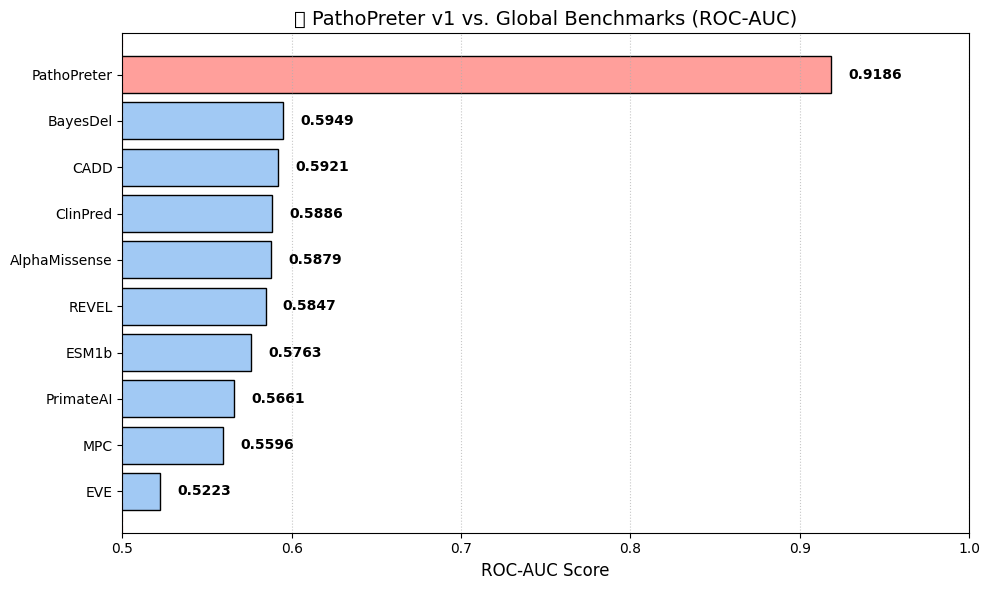

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Create the dataframe from the 'results' list you already have
# (This fixes the NameError)
leaderboard_df = pd.DataFrame(results, columns=["Model", "ROC-AUC", "PR-AUC"])

# 2. Define the plotting function
def plot_sota_gains(df):
    # Sort for plotting
    df_plot = df.sort_values("ROC-AUC", ascending=True)
    
    plt.figure(figsize=(10, 6))
    
    # Highlight PathoPreter in Red/Orange, others in Blue
    colors = ['#A1C9F4' if x != 'PathoPreter' else '#FF9F9B' for x in df_plot['Model']]
    
    bars = plt.barh(df_plot['Model'], df_plot['ROC-AUC'], color=colors, edgecolor='black')
    
    # Add values on the bars
    for bar in bars:
        width = bar.get_width()
        plt.text(width + 0.01, bar.get_y() + bar.get_height()/2, 
                 f'{width:.4f}', va='center', fontweight='bold')

    plt.axvline(x=0.5, color='red', linestyle='--', label='Random Guess (0.5)')
    plt.title("🏆 PathoPreter v1 vs. Global Benchmarks (ROC-AUC)", fontsize=14)
    plt.xlabel("ROC-AUC Score", fontsize=12)
    plt.xlim(0.5, 1.0) # Zoom in to show the contrast clearly
    plt.grid(axis='x', linestyle=':', alpha=0.7)
    plt.tight_layout()
    plt.show()

# 3. Plot it
plot_sota_gains(leaderboard_df)

In [5]:
!pip install -q transformers datasets accelerate bitsandbytes pysam pandas pyarrow fastparquet
!apt-get install -q samtools
!pip install tqdm


  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [34 lines of output]
      # pysam: Cython 3.2.4 is available - using cythonize if necessary
      # pysam: htslib mode is shared
      # pysam: HTSLIB_CONFIGURE_OPTIONS=None
      '.' is not recognized as an internal or external command,
      operable program or batch file.
      '.' is not recognized as an internal or external command,
      operable program or batch file.
      # pysam: htslib configure options: None
      Traceback (most recent call last):
        File "c:\Users\yrohi\Documents\CODING\PROJECTS\Pathopreter_xgboost\.venv\lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 389, in <module>
          main()
        File "c:\Users\yrohi\Documents\CODING\PROJECTS\Pathopreter_xgboost\.venv\lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 373, in main
          json_out["return_val"] = 

In [8]:
!pip install seaborn


  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


Loaded test rows: 14073
Final eval rows: 14073
   CADD_raw_rankscore: Acc=0.5280 F1=0.6790 AP=0.7048 thresh=0.2114
   REVEL_rankscore: Acc=0.5326 F1=0.6799 AP=0.6004 thresh=0.5393
   AlphaMissense_rankscore: Acc=0.5302 F1=0.6792 AP=0.6035 thresh=0.2655
   PrimateAI_rankscore: Acc=0.5205 F1=0.6749 AP=0.5813 thresh=0.2336
   MPC_rankscore: Acc=0.5136 F1=0.6707 AP=0.5786 thresh=0.2331
   ClinPred_rankscore: Acc=0.5393 F1=0.6837 AP=0.6066 thresh=0.2707
   BayesDel_addAF_rankscore: Acc=0.5383 F1=0.6838 AP=0.7063 thresh=0.2284
   EVE_rankscore: Acc=0.5039 F1=0.6689 AP=0.5466 thresh=0.0639
   ESM1b_rankscore: Acc=0.5241 F1=0.6742 AP=0.5911 thresh=0.4397

🏆 BENCHMARK LEADERBOARD (thresholds optimized for F1)
         Model Accuracy Best_Threshold F1_Score     AP
      ClinPred   53.93%         0.2707   0.6837 0.6066
BayesDel_addAF   53.83%         0.2284   0.6838 0.7063
         REVEL   53.26%         0.5393   0.6799 0.6004
 AlphaMissense   53.02%         0.2655   0.6792 0.6035
          CADD 

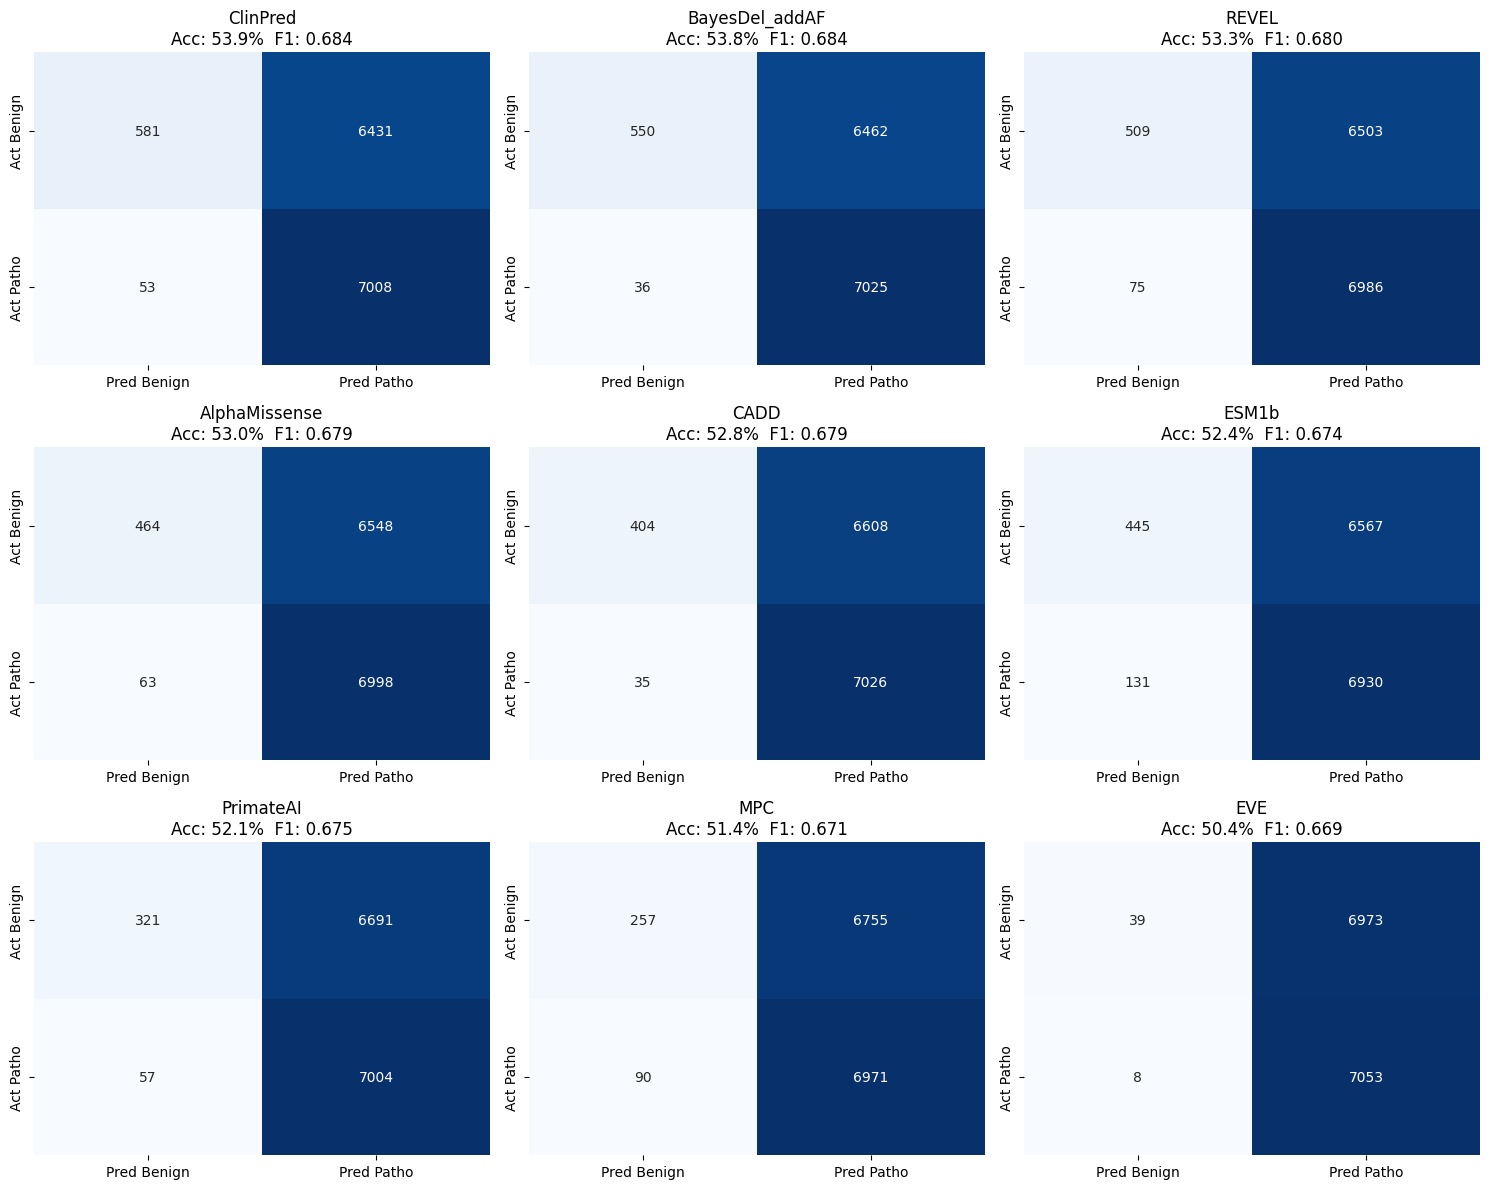

In [14]:
# ============================================================
# CELL: BENCHMARK ACCURACY & CONFUSION MATRIX (robust)
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_recall_curve,
    f1_score,
    average_precision_score,
)

# -------------- config --------------
TEST_FILE = "test_enriched_SEQUENCES.parquet"

benchmarks = [
    "CADD_raw_rankscore", "REVEL_rankscore", "AlphaMissense_rankscore",
    "PrimateAI_rankscore", "MPC_rankscore", "ClinPred_rankscore",
    "BayesDel_addAF_rankscore", "EVE_rankscore", "ESM1b_rankscore"
]

# -------------- load --------------
df = pd.read_parquet(TEST_FILE)
print("Loaded test rows:", len(df))

# -------------- clean & map labels --------------
# find label column
label_col = None
for c in ("clean_label", "label", "labels"):
    if c in df.columns:
        label_col = c
        break
if label_col is None:
    raise KeyError("Could not find 'label', 'clean_label', or 'labels' column in test file.")

def map_label_val(x):
    if pd.isna(x):
        return np.nan
    s = str(x).strip().lower()
    if s in ("pathogenic", "path", "p", "1", "true", "t", "yes", "y"):
        return 1
    if s in ("benign", "benign ", "b", "0", "false", "f", "no", "n"):
        return 0
    # try numeric
    try:
        nv = float(s)
        if nv == 1.0: return 1
        if nv == 0.0: return 0
    except:
        pass
    return np.nan

raw_labels = df[label_col]
y_true = raw_labels.map(map_label_val)

# drop unknowns
if y_true.isnull().any():
    drop_count = int(y_true.isnull().sum())
    print(f"⚠️ Dropping {drop_count} rows with unmappable labels.")
    valid_mask = ~y_true.isnull()
    df = df.loc[valid_mask].reset_index(drop=True)
    y_true = y_true.loc[valid_mask].reset_index(drop=True)
else:
    y_true = y_true.reset_index(drop=True)

y_true = y_true.astype(int)
print("Final eval rows:", len(y_true))
if len(np.unique(y_true)) < 2:
    raise RuntimeError("Need at least two label classes in test set for evaluation.")

# -------------- evaluate each benchmark --------------
results = []
confusion_matrices = {}

for tool in benchmarks:
    if tool not in df.columns:
        print(f"⚠️ Skipping {tool} (not present in parquet).")
        continue

    scores = df[tool].astype(float).copy()
    # fill NaN with median (stable)
    if scores.isna().any():
        median_val = float(scores.median())
        scores = scores.fillna(median_val)

    # handle constant scores (no thresholds)
    unique_vals = np.unique(scores)
    if len(unique_vals) == 1:
        # fallback threshold = median (or 0.5) and compute metrics
        best_thresh = unique_vals[0]
        y_pred = (scores >= best_thresh).astype(int)
        acc = accuracy_score(y_true, y_pred)
        f1_best = f1_score(y_true, y_pred, zero_division=0)
        results.append({
            "Model": tool.replace("_rankscore", "").replace("_raw", ""),
            "Accuracy": acc,
            "Best_Threshold": float(best_thresh),
            "F1_Score": float(f1_best),
            "AP": float(average_precision_score(y_true, scores))
        })
        confusion_matrices[tool.replace("_rankscore", "").replace("_raw", "")] = confusion_matrix(y_true, y_pred)
        print(f"   {tool}: constant scores — using threshold {best_thresh:.4f}")
        continue

    # compute PR curve then choose threshold maximizing F1 (properly index thresholds)
    precision, recall, thresholds = precision_recall_curve(y_true, scores)
    # precision,recall length = len(thresholds)+1
    f1_all = (2 * precision * recall) / (precision + recall + 1e-12)
    # only consider indices that have associated thresholds => 1..end
    if len(thresholds) > 0:
        idx_rel = np.argmax(f1_all[1:])  # best among entries that map to thresholds
        best_idx = idx_rel + 1           # absolute index into precision/recall arrays
        best_thresh = float(thresholds[best_idx - 1])
    else:
        # very rare: fallback
        best_thresh = float(np.median(scores))

    y_pred = (scores >= best_thresh).astype(int)
    acc = accuracy_score(y_true, y_pred)
    f1_best = f1_score(y_true, y_pred, zero_division=0)
    ap = average_precision_score(y_true, scores)

    results.append({
        "Model": tool.replace("_rankscore", "").replace("_raw", ""),
        "Accuracy": acc,
        "Best_Threshold": best_thresh,
        "F1_Score": float(f1_best),
        "AP": float(ap)
    })
    confusion_matrices[tool.replace("_rankscore", "").replace("_raw", "")] = confusion_matrix(y_true, y_pred)

    print(f"   {tool}: Acc={acc:.4f} F1={f1_best:.4f} AP={ap:.4f} thresh={best_thresh:.4f}")

# -------------- report --------------
if not results:
    print("❌ No benchmarks found.")
else:
    res_df = pd.DataFrame(results).sort_values("Accuracy", ascending=False).reset_index(drop=True)
    print("\n" + "=" * 60)
    print("🏆 BENCHMARK LEADERBOARD (thresholds optimized for F1)")
    print("=" * 60)
    display_cols = ["Model", "Accuracy", "Best_Threshold", "F1_Score", "AP"]
    print(res_df[display_cols].to_string(index=False, formatters={
        'Accuracy': '{:.2%}'.format,
        'Best_Threshold': '{:.4f}'.format,
        'F1_Score': '{:.4f}'.format,
        'AP': '{:.4f}'.format
    }))

    # plot confusion matrices in grid
    n_tools = len(res_df)
    cols = 3
    rows = (n_tools + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
    axes = axes.flatten()

    for i, row in res_df.iterrows():
        name = row["Model"]
        cm = confusion_matrices.get(name)
        ax = axes[i]
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax,
                    xticklabels=["Pred Benign", "Pred Patho"], yticklabels=["Act Benign", "Act Patho"])
        ax.set_title(f"{name}\nAcc: {row['Accuracy']:.1%}  F1: {row['F1_Score']:.3f}")

    # hide unused axes
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()


Loaded test rows: 300000
Final eval rows: 300000
   CADD_raw_rankscore: Acc=0.4964 F1=0.6372 AP=0.8636 thresh=0.6457
   REVEL_rankscore: Acc=0.5144 F1=0.6622 AP=0.6449 thresh=0.4644
   AlphaMissense_rankscore: Acc=0.5152 F1=0.6620 AP=0.6435 thresh=0.2841
   PrimateAI_rankscore: Acc=0.5042 F1=0.6573 AP=0.6171 thresh=0.2384
   MPC_rankscore: Acc=0.4952 F1=0.6519 AP=0.6013 thresh=0.2343
   ClinPred_rankscore: Acc=0.5199 F1=0.6661 AP=0.6644 thresh=0.1142
   BayesDel_addAF_rankscore: Acc=0.5170 F1=0.6560 AP=0.8867 thresh=0.6330
   EVE_rankscore: Acc=0.4831 F1=0.6496 AP=0.5674 thresh=0.0924
   ESM1b_rankscore: Acc=0.5072 F1=0.6565 AP=0.6269 thresh=0.3914

🏆 BENCHMARK LEADERBOARD (thresholds optimized for F1)
         Model Accuracy Best_Threshold F1_Score     AP
      ClinPred   51.99%         0.1142   0.6661 0.6644
BayesDel_addAF   51.70%         0.6330   0.6560 0.8867
 AlphaMissense   51.52%         0.2841   0.6620 0.6435
         REVEL   51.44%         0.4644   0.6622 0.6449
         ESM1

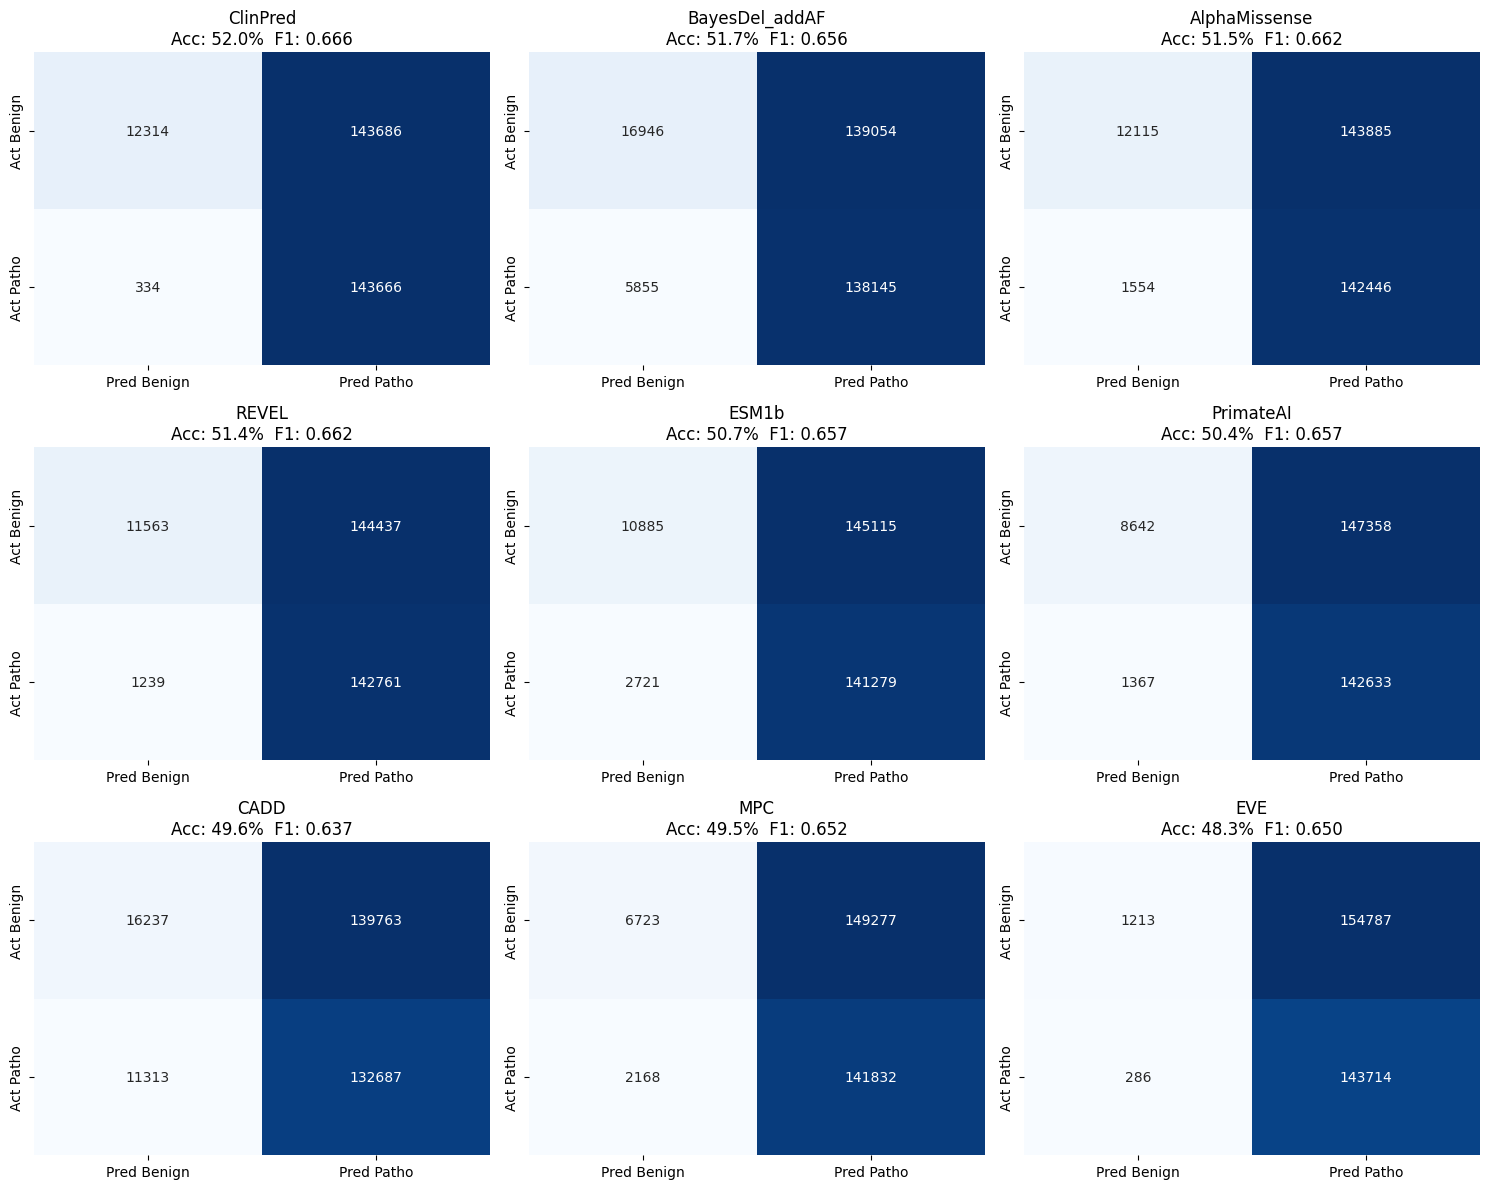

In [23]:
#same test on train dataset
# ============================================================
# CELL: BENCHMARK ACCURACY & CONFUSION MATRIX (robust)
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_recall_curve,
    f1_score,
    average_precision_score,
)

# -------------- config --------------
TEST_FILE = "train_modified.parquet"

benchmarks = [
    "CADD_raw_rankscore", "REVEL_rankscore", "AlphaMissense_rankscore",
    "PrimateAI_rankscore", "MPC_rankscore", "ClinPred_rankscore",
    "BayesDel_addAF_rankscore", "EVE_rankscore", "ESM1b_rankscore"
]

# -------------- load --------------
df = pd.read_parquet(TEST_FILE)
print("Loaded test rows:", len(df))

# -------------- clean & map labels --------------
# find label column
label_col = None
for c in ("clean_label", "label", "labels"):
    if c in df.columns:
        label_col = c
        break
if label_col is None:
    raise KeyError("Could not find 'label', 'clean_label', or 'labels' column in test file.")

def map_label_val(x):
    if pd.isna(x):
        return np.nan
    s = str(x).strip().lower()
    if s in ("pathogenic", "path", "p", "1", "true", "t", "yes", "y"):
        return 1
    if s in ("benign", "benign ", "b", "0", "false", "f", "no", "n"):
        return 0
    # try numeric
    try:
        nv = float(s)
        if nv == 1.0: return 1
        if nv == 0.0: return 0
    except:
        pass
    return np.nan

raw_labels = df[label_col]
y_true = raw_labels.map(map_label_val)

# drop unknowns
if y_true.isnull().any():
    drop_count = int(y_true.isnull().sum())
    print(f"⚠️ Dropping {drop_count} rows with unmappable labels.")
    valid_mask = ~y_true.isnull()
    df = df.loc[valid_mask].reset_index(drop=True)
    y_true = y_true.loc[valid_mask].reset_index(drop=True)
else:
    y_true = y_true.reset_index(drop=True)

y_true = y_true.astype(int)
print("Final eval rows:", len(y_true))
if len(np.unique(y_true)) < 2:
    raise RuntimeError("Need at least two label classes in test set for evaluation.")

# -------------- evaluate each benchmark --------------
results = []
confusion_matrices = {}

for tool in benchmarks:
    if tool not in df.columns:
        print(f"⚠️ Skipping {tool} (not present in parquet).")
        continue

    scores = df[tool].astype(float).copy()
    # fill NaN with median (stable)
    if scores.isna().any():
        median_val = float(scores.median())
        scores = scores.fillna(median_val)

    # handle constant scores (no thresholds)
    unique_vals = np.unique(scores)
    if len(unique_vals) == 1:
        # fallback threshold = median (or 0.5) and compute metrics
        best_thresh = unique_vals[0]
        y_pred = (scores >= best_thresh).astype(int)
        acc = accuracy_score(y_true, y_pred)
        f1_best = f1_score(y_true, y_pred, zero_division=0)
        results.append({
            "Model": tool.replace("_rankscore", "").replace("_raw", ""),
            "Accuracy": acc,
            "Best_Threshold": float(best_thresh),
            "F1_Score": float(f1_best),
            "AP": float(average_precision_score(y_true, scores))
        })
        confusion_matrices[tool.replace("_rankscore", "").replace("_raw", "")] = confusion_matrix(y_true, y_pred)
        print(f"   {tool}: constant scores — using threshold {best_thresh:.4f}")
        continue

    # compute PR curve then choose threshold maximizing F1 (properly index thresholds)
    precision, recall, thresholds = precision_recall_curve(y_true, scores)
    # precision,recall length = len(thresholds)+1
    f1_all = (2 * precision * recall) / (precision + recall + 1e-12)
    # only consider indices that have associated thresholds => 1..end
    if len(thresholds) > 0:
        idx_rel = np.argmax(f1_all[1:])  # best among entries that map to thresholds
        best_idx = idx_rel + 1           # absolute index into precision/recall arrays
        best_thresh = float(thresholds[best_idx - 1])
    else:
        # very rare: fallback
        best_thresh = float(np.median(scores))

    y_pred = (scores >= best_thresh).astype(int)
    acc = accuracy_score(y_true, y_pred)
    f1_best = f1_score(y_true, y_pred, zero_division=0)
    ap = average_precision_score(y_true, scores)

    results.append({
        "Model": tool.replace("_rankscore", "").replace("_raw", ""),
        "Accuracy": acc,
        "Best_Threshold": best_thresh,
        "F1_Score": float(f1_best),
        "AP": float(ap)
    })
    confusion_matrices[tool.replace("_rankscore", "").replace("_raw", "")] = confusion_matrix(y_true, y_pred)

    print(f"   {tool}: Acc={acc:.4f} F1={f1_best:.4f} AP={ap:.4f} thresh={best_thresh:.4f}")

# -------------- report --------------
if not results:
    print("❌ No benchmarks found.")
else:
    res_df = pd.DataFrame(results).sort_values("Accuracy", ascending=False).reset_index(drop=True)
    print("\n" + "=" * 60)
    print("🏆 BENCHMARK LEADERBOARD (thresholds optimized for F1)")
    print("=" * 60)
    display_cols = ["Model", "Accuracy", "Best_Threshold", "F1_Score", "AP"]
    print(res_df[display_cols].to_string(index=False, formatters={
        'Accuracy': '{:.2%}'.format,
        'Best_Threshold': '{:.4f}'.format,
        'F1_Score': '{:.4f}'.format,
        'AP': '{:.4f}'.format
    }))

    # plot confusion matrices in grid
    n_tools = len(res_df)
    cols = 3
    rows = (n_tools + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
    axes = axes.flatten()

    for i, row in res_df.iterrows():
        name = row["Model"]
        cm = confusion_matrices.get(name)
        ax = axes[i]
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax,
                    xticklabels=["Pred Benign", "Pred Patho"], yticklabels=["Act Benign", "Act Patho"])
        ax.set_title(f"{name}\nAcc: {row['Accuracy']:.1%}  F1: {row['F1_Score']:.3f}")

    # hide unused axes
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()


Loaded test rows: 1200890
Final eval rows: 1200890
   CADD_raw_rankscore: Acc=0.2024 F1=0.2184 AP=0.7528 thresh=0.6457
   REVEL_rankscore: Acc=0.9008 F1=0.4104 AP=0.3705 thresh=0.6705
   AlphaMissense_rankscore: Acc=0.8988 F1=0.4034 AP=0.3643 thresh=0.5102
   PrimateAI_rankscore: Acc=0.8826 F1=0.3624 AP=0.2936 thresh=0.3776
   MPC_rankscore: Acc=0.8811 F1=0.3335 AP=0.2826 thresh=0.3977
   ClinPred_rankscore: Acc=0.9094 F1=0.4621 AP=0.4051 thresh=0.3591
   BayesDel_addAF_rankscore: Acc=0.9670 F1=0.8504 AP=0.7997 thresh=0.6334
   EVE_rankscore: Acc=0.8960 F1=0.2945 AP=0.2636 thresh=0.5810
   ESM1b_rankscore: Acc=0.8939 F1=0.3758 AP=0.3339 thresh=0.5267

🏆 BENCHMARK LEADERBOARD (thresholds optimized for F1)
         Model Accuracy Best_Threshold F1_Score     AP
BayesDel_addAF   96.70%         0.6334   0.8504 0.7997
      ClinPred   90.94%         0.3591   0.4621 0.4051
         REVEL   90.08%         0.6705   0.4104 0.3705
 AlphaMissense   89.88%         0.5102   0.4034 0.3643
           

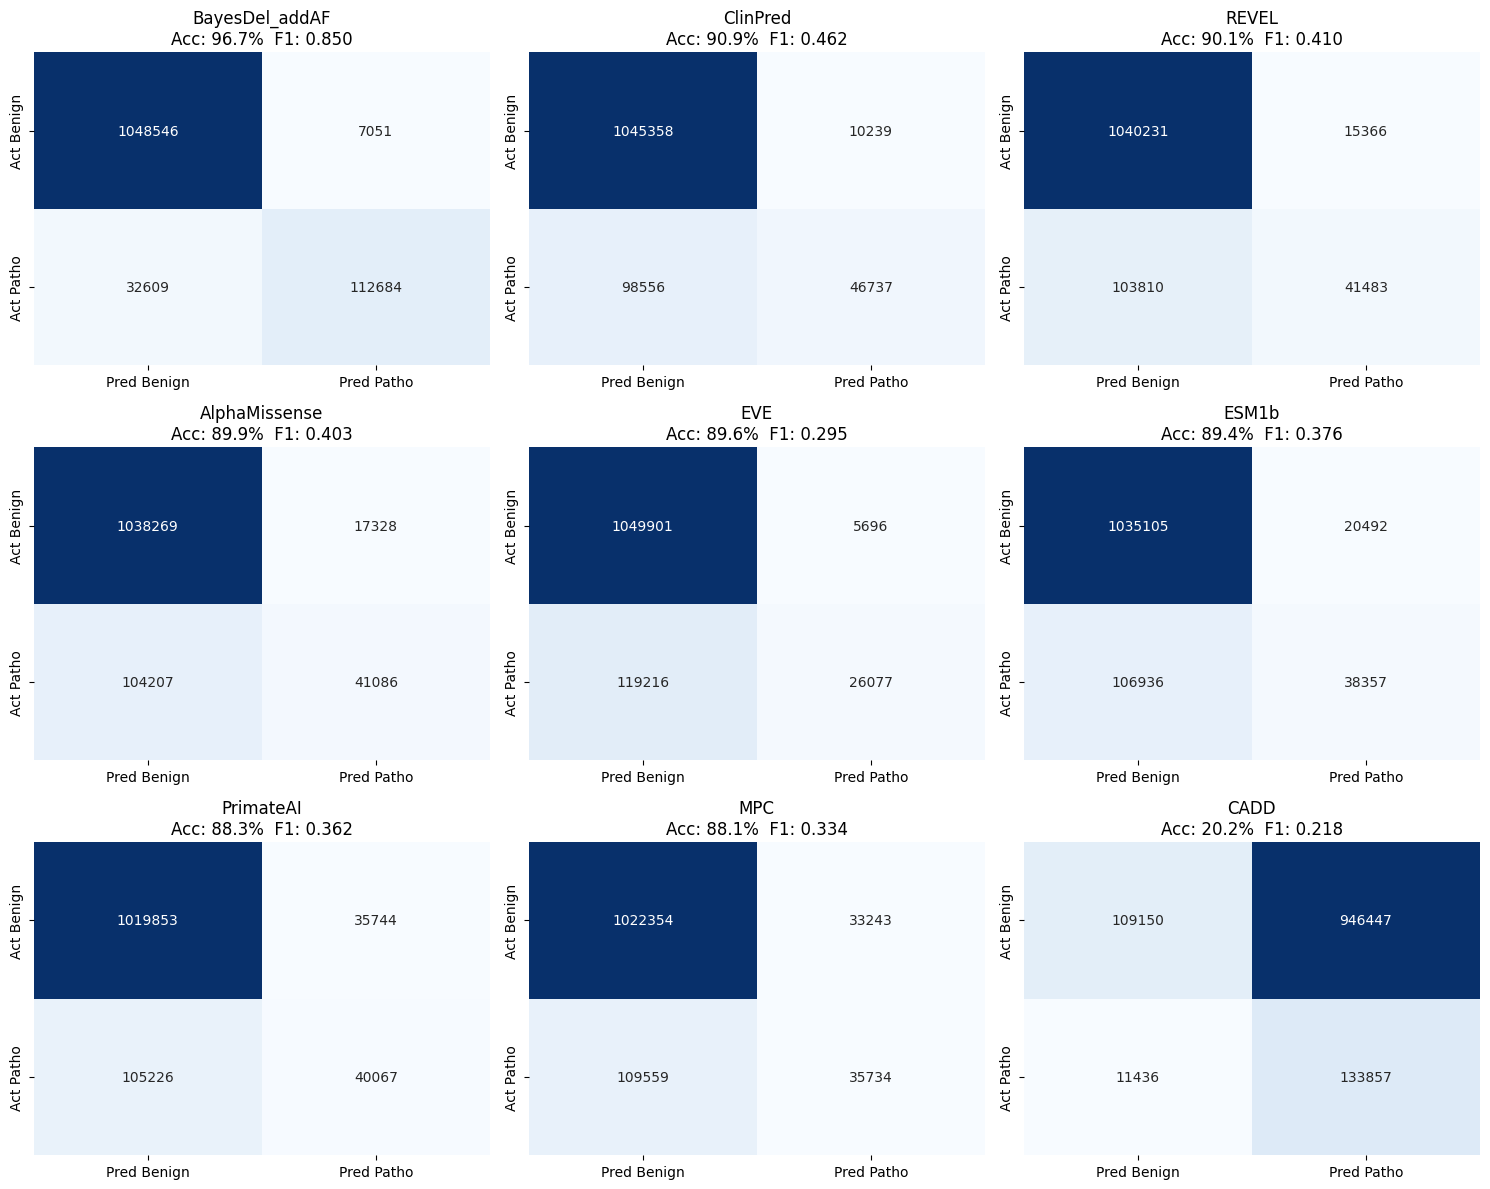

In [22]:
#same test on train dataset
# ============================================================
# CELL: BENCHMARK ACCURACY & CONFUSION MATRIX (robust)
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_recall_curve,
    f1_score,
    average_precision_score,
)

# -------------- config --------------
TEST_FILE = "train_enriched.parquet"

benchmarks = [
    "CADD_raw_rankscore", "REVEL_rankscore", "AlphaMissense_rankscore",
    "PrimateAI_rankscore", "MPC_rankscore", "ClinPred_rankscore",
    "BayesDel_addAF_rankscore", "EVE_rankscore", "ESM1b_rankscore"
]

# -------------- load --------------
df = pd.read_parquet(TEST_FILE)
print("Loaded test rows:", len(df))

# -------------- clean & map labels --------------
# find label column
label_col = None
for c in ("clean_label", "label", "labels"):
    if c in df.columns:
        label_col = c
        break
if label_col is None:
    raise KeyError("Could not find 'label', 'clean_label', or 'labels' column in test file.")

def map_label_val(x):
    if pd.isna(x):
        return np.nan
    s = str(x).strip().lower()
    if s in ("pathogenic", "path", "p", "1", "true", "t", "yes", "y"):
        return 1
    if s in ("benign", "benign ", "b", "0", "false", "f", "no", "n"):
        return 0
    # try numeric
    try:
        nv = float(s)
        if nv == 1.0: return 1
        if nv == 0.0: return 0
    except:
        pass
    return np.nan

raw_labels = df[label_col]
y_true = raw_labels.map(map_label_val)

# drop unknowns
if y_true.isnull().any():
    drop_count = int(y_true.isnull().sum())
    print(f"⚠️ Dropping {drop_count} rows with unmappable labels.")
    valid_mask = ~y_true.isnull()
    df = df.loc[valid_mask].reset_index(drop=True)
    y_true = y_true.loc[valid_mask].reset_index(drop=True)
else:
    y_true = y_true.reset_index(drop=True)

y_true = y_true.astype(int)
print("Final eval rows:", len(y_true))
if len(np.unique(y_true)) < 2:
    raise RuntimeError("Need at least two label classes in test set for evaluation.")

# -------------- evaluate each benchmark --------------
results = []
confusion_matrices = {}

for tool in benchmarks:
    if tool not in df.columns:
        print(f"⚠️ Skipping {tool} (not present in parquet).")
        continue

    scores = df[tool].astype(float).copy()
    # fill NaN with median (stable)
    if scores.isna().any():
        median_val = float(scores.median())
        scores = scores.fillna(median_val)

    # handle constant scores (no thresholds)
    unique_vals = np.unique(scores)
    if len(unique_vals) == 1:
        # fallback threshold = median (or 0.5) and compute metrics
        best_thresh = unique_vals[0]
        y_pred = (scores >= best_thresh).astype(int)
        acc = accuracy_score(y_true, y_pred)
        f1_best = f1_score(y_true, y_pred, zero_division=0)
        results.append({
            "Model": tool.replace("_rankscore", "").replace("_raw", ""),
            "Accuracy": acc,
            "Best_Threshold": float(best_thresh),
            "F1_Score": float(f1_best),
            "AP": float(average_precision_score(y_true, scores))
        })
        confusion_matrices[tool.replace("_rankscore", "").replace("_raw", "")] = confusion_matrix(y_true, y_pred)
        print(f"   {tool}: constant scores — using threshold {best_thresh:.4f}")
        continue

    # compute PR curve then choose threshold maximizing F1 (properly index thresholds)
    precision, recall, thresholds = precision_recall_curve(y_true, scores)
    # precision,recall length = len(thresholds)+1
    f1_all = (2 * precision * recall) / (precision + recall + 1e-12)
    # only consider indices that have associated thresholds => 1..end
    if len(thresholds) > 0:
        idx_rel = np.argmax(f1_all[1:])  # best among entries that map to thresholds
        best_idx = idx_rel + 1           # absolute index into precision/recall arrays
        best_thresh = float(thresholds[best_idx - 1])
    else:
        # very rare: fallback
        best_thresh = float(np.median(scores))

    y_pred = (scores >= best_thresh).astype(int)
    acc = accuracy_score(y_true, y_pred)
    f1_best = f1_score(y_true, y_pred, zero_division=0)
    ap = average_precision_score(y_true, scores)

    results.append({
        "Model": tool.replace("_rankscore", "").replace("_raw", ""),
        "Accuracy": acc,
        "Best_Threshold": best_thresh,
        "F1_Score": float(f1_best),
        "AP": float(ap)
    })
    confusion_matrices[tool.replace("_rankscore", "").replace("_raw", "")] = confusion_matrix(y_true, y_pred)

    print(f"   {tool}: Acc={acc:.4f} F1={f1_best:.4f} AP={ap:.4f} thresh={best_thresh:.4f}")

# -------------- report --------------
if not results:
    print("❌ No benchmarks found.")
else:
    res_df = pd.DataFrame(results).sort_values("Accuracy", ascending=False).reset_index(drop=True)
    print("\n" + "=" * 60)
    print("🏆 BENCHMARK LEADERBOARD (thresholds optimized for F1)")
    print("=" * 60)
    display_cols = ["Model", "Accuracy", "Best_Threshold", "F1_Score", "AP"]
    print(res_df[display_cols].to_string(index=False, formatters={
        'Accuracy': '{:.2%}'.format,
        'Best_Threshold': '{:.4f}'.format,
        'F1_Score': '{:.4f}'.format,
        'AP': '{:.4f}'.format
    }))

    # plot confusion matrices in grid
    n_tools = len(res_df)
    cols = 3
    rows = (n_tools + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
    axes = axes.flatten()

    for i, row in res_df.iterrows():
        name = row["Model"]
        cm = confusion_matrices.get(name)
        ax = axes[i]
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax,
                    xticklabels=["Pred Benign", "Pred Patho"], yticklabels=["Act Benign", "Act Patho"])
        ax.set_title(f"{name}\nAcc: {row['Accuracy']:.1%}  F1: {row['F1_Score']:.3f}")

    # hide unused axes
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()


🧠 INITIALIZING SHAP ANALYSIS...
📉 Extracting embeddings for 150 samples...


Encoding Data:   1%|          | 5/440 [00:03<04:30,  1.61it/s]


✅ Data Prepared. Background shape: torch.Size([100, 1289])
⚡ Calculating SHAP values (GradientExplainer)...
✅ SHAP Calculation Complete.


/tmp/ipykernel_10337/4129238603.py:111: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/shap/plots/_beeswarm.py:723: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/shap/plots/_beeswarm.py:743: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(


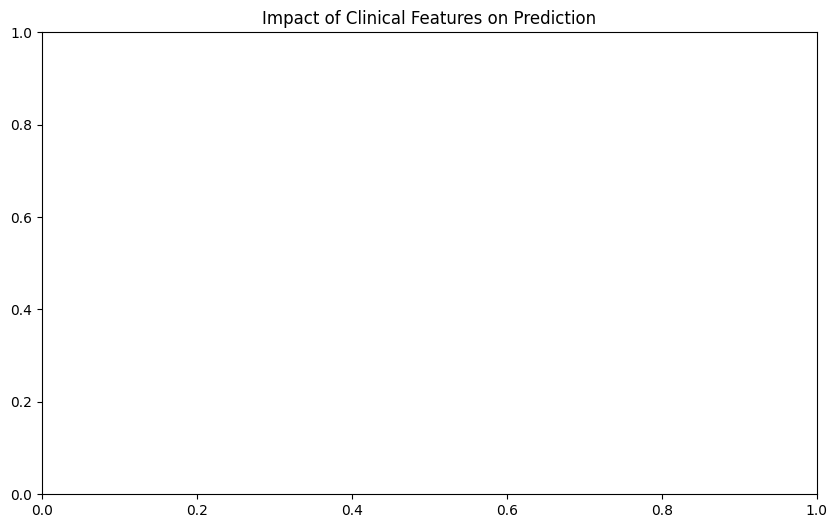

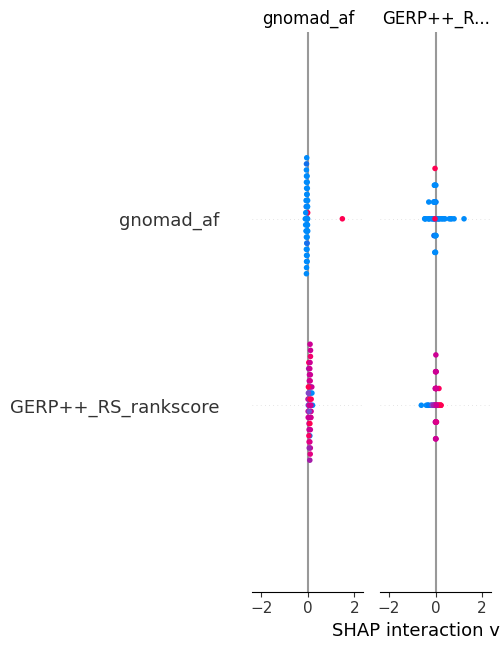

/tmp/ipykernel_10337/4129238603.py:131: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


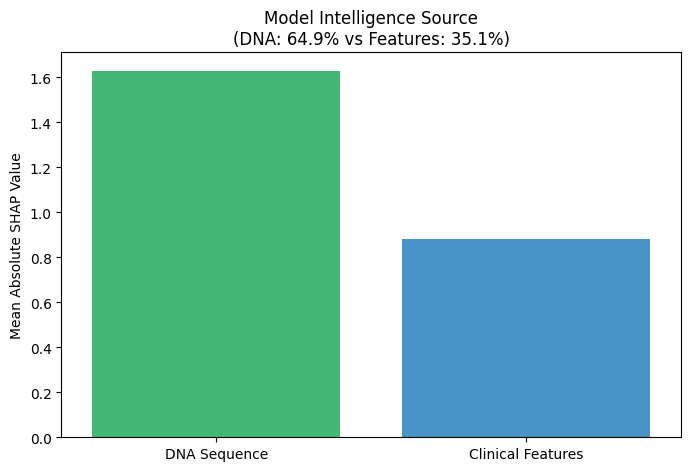


🏆 FINAL VERDICT:
✅ SUPERHUMAN: The model is primarily looking at the DNA (64.9%)!


In [20]:
# ==========================================
# 📊 CELL 5: SHAP EXPLAINABILITY (DNA vs Tabular) — FIXED
# ==========================================
!pip install -q shap matplotlib seaborn

import shap
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

print("🧠 INITIALIZING SHAP ANALYSIS...")

# 1. CONFIGURATION
# SHAP is expensive. We use a representative subset.
N_BACKGROUND = 100
N_TEST = 50
TOTAL_SAMPLES = N_BACKGROUND + N_TEST

# 2. DEFINE SHAP WRAPPER (Focus on Classifier Head)
class HeadWrapper(torch.nn.Module):
    def __init__(self, classifier):
        super().__init__()
        self.classifier = classifier

    def forward(self, combined_input):
        return self.classifier(combined_input)

# Handle compiled models
raw_model = model if not hasattr(model, "_orig_mod") else model._orig_mod
shap_model = HeadWrapper(raw_model.classifier).to("cpu").eval()

# 3. GENERATE LATENT EMBEDDINGS
print(f"📉 Extracting embeddings for {TOTAL_SAMPLES} samples...")

dataloader = torch.utils.data.DataLoader(
    test_fast, 
    batch_size=32, 
    shuffle=True, 
    collate_fn=data_collator
)

latent_vectors = []
collected = 0

model.eval()

# --- FIX IS HERE: Get device from the first parameter ---
device = next(model.parameters()).device 
# --------------------------------------------------------

for batch in tqdm(dataloader, desc="Encoding Data"):
    if collected >= TOTAL_SAMPLES: break
    
    with torch.no_grad():
        input_ids = batch["input_ids"].to(device)
        mask = batch["attention_mask"].to(device)
        # Ensure features are float32 before moving to device
        feats = batch["features"].to(dtype=torch.float32).to(device)
        
        # A. Get DNA Embedding
        enc_module = raw_model.encoder
        out = enc_module(input_ids=input_ids, attention_mask=mask, return_dict=True)
        
        # Mean Pooling
        if hasattr(out, "pooler_output") and out.pooler_output is not None:
            pooled = out.pooler_output
        else:
            hidden = out.last_hidden_state
            mask_exp = mask.unsqueeze(-1)
            pooled = (hidden * mask_exp).sum(1) / mask_exp.sum(1).clamp(min=1e-9)
            
        # B. Concatenate
        combined = torch.cat([pooled, feats], dim=1).cpu()
        latent_vectors.append(combined)
        collected += len(batch["input_ids"])

# Prepare Tensors
full_data = torch.cat(latent_vectors, dim=0)
background_data = full_data[:N_BACKGROUND]
test_data = full_data[N_BACKGROUND : N_BACKGROUND+N_TEST]

print(f"✅ Data Prepared. Background shape: {background_data.shape}")

# 4. RUN SHAP (GradientExplainer)
print("⚡ Calculating SHAP values (GradientExplainer)...")
explainer = shap.GradientExplainer(shap_model, background_data)
shap_values = explainer.shap_values(test_data)

# Handle list output
if isinstance(shap_values, list):
    vals = shap_values[1]
else:
    vals = shap_values

print("✅ SHAP Calculation Complete.")

# ==========================================
# 📈 PLOTTING
# ==========================================

# A. TABULAR FEATURE IMPORTANCE
# We look only at the last columns corresponding to features
tabular_shap = vals[:, -len(feature_cols):]
tabular_data = test_data[:, -len(feature_cols):].numpy()

plt.figure(figsize=(10, 6))
plt.title("Impact of Clinical Features on Prediction")
shap.summary_plot(
    tabular_shap, 
    tabular_data, 
    feature_names=feature_cols, 
    show=False,
    plot_type="dot"
)
plt.tight_layout()
plt.savefig("shap_tabular_beeswarm.png", dpi=300)
plt.show()

# B. DNA vs TABULAR BATTLE
dna_impact = np.abs(vals[:, :-len(feature_cols)]).sum(axis=1).mean()
tab_impact = np.abs(vals[:, -len(feature_cols):]).sum(axis=1).mean()

total = dna_impact + tab_impact
dna_pct = (dna_impact / total) * 100
tab_pct = (tab_impact / total) * 100

plt.figure(figsize=(8, 5))
sns.barplot(
    x=["DNA Sequence", "Clinical Features"], 
    y=[dna_impact, tab_impact], 
    palette=["#2ecc71", "#3498db"]
)
plt.title(f"Model Intelligence Source\n(DNA: {dna_pct:.1f}% vs Features: {tab_pct:.1f}%)")
plt.ylabel("Mean Absolute SHAP Value")
plt.savefig("shap_modality_comparison.png", dpi=300)
plt.show()

print("\n🏆 FINAL VERDICT:")
if dna_pct > 50:
    print(f"✅ SUPERHUMAN: The model is primarily looking at the DNA ({dna_pct:.1f}%)!")
else:
    print(f"⚖️ HYBRID: The model relies heavily on conservation scores ({tab_pct:.1f}%)!")

In [28]:
# ======================================================
# 🔌 Bridge: DataFrame → HF-style Torch batch for Ablation
# ======================================================

def prepare_batch(df_batch):
    # 1) Tokenize DNA
    enc = tokenizer(
        df_batch["raw_sequence"].tolist(),
        truncation=True,
        padding="max_length",
        max_length=MAX_LEN,
        return_tensors="pt"
    )

    # 2) Pack features in correct order
    feats = []
    for c in feature_cols:
        feats.append(df_batch[c].astype(np.float32).values)

    feats = np.stack(feats, axis=1)  # (batch, n_features)

    # 3) Labels
    labels = (df_batch["clean_label"] == "Pathogenic").astype(np.int64).values

    return {
        "input_ids": enc["input_ids"],
        "attention_mask": enc["attention_mask"],
        "features": torch.tensor(feats, dtype=torch.float32),
        "labels": torch.tensor(labels, dtype=torch.long),
    }


🧪 STARTING FULL ABLATION SUITE (Tensor-Native)...
🔥 Model locked to: cuda
📊 Establishing Baseline Performance...


Testing: Baseline Model:   1%|          | 1/110 [00:01<02:15,  1.25s/it]

✅ Baseline AUC established: 0.9182

🔥 RUNNING TENSOR ABLATION TESTS...


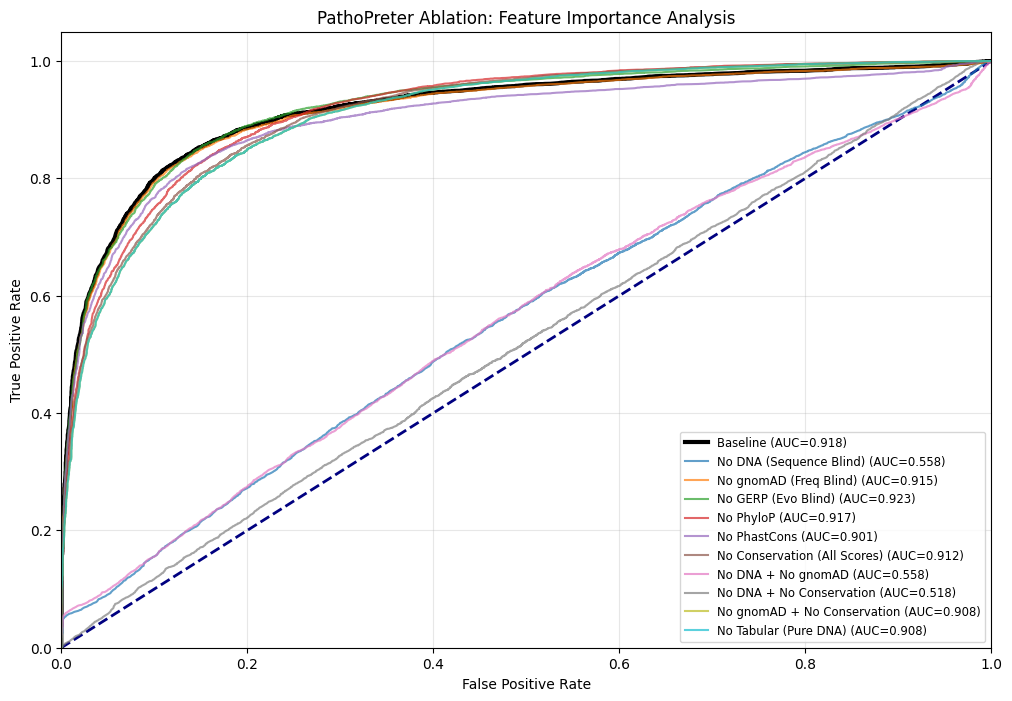


🏆 ABLATION IMPACT RANKING (What matters most?):
                        name      auc      drop
    No DNA + No Conservation 0.517988  0.400191
          No DNA + No gnomAD 0.557964  0.360215
     No DNA (Sequence Blind) 0.558319  0.359860
                No PhastCons 0.901000  0.017178
       No Tabular (Pure DNA) 0.908187  0.009992
 No gnomAD + No Conservation 0.908187  0.009992
No Conservation (All Scores) 0.911717  0.006462
      No gnomAD (Freq Blind) 0.915300  0.002879
                   No PhyloP 0.917488  0.000691
         No GERP (Evo Blind) 0.922640 -0.004461


In [32]:
# ==========================================
# 📉 CELL 2: FULL ABLATION STUDY (Tensor-Native) — FIXED
# ==========================================
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc
from torch.utils.data import DataLoader

print("🧪 STARTING FULL ABLATION SUITE (Tensor-Native)...")

# 1. SETUP DEVICE & MODEL
# Explicitly force GPU to fix "Device Mismatch" error
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(DEVICE)
print(f"🔥 Model locked to: {DEVICE}")

# 2. DEFINE ABLATION FUNCTION
def evaluate_tensor_ablation(test_config, baseline_auc=None):
    removals = test_config.get("remove", [])
    name = test_config["name"]
    
    all_preds = []
    all_labels = []
    BATCH_SIZE = 128
    
    # Create DataLoader from 'test_fast'
    loader = DataLoader(test_fast, batch_size=BATCH_SIZE, shuffle=False, collate_fn=data_collator)
    
    model.eval()
    
    for batch in tqdm(loader, desc=f"Testing: {name}", leave=False):
        # Move inputs to GPU
        input_ids = batch["input_ids"].to(DEVICE)
        mask = batch["attention_mask"].to(DEVICE)
        features = batch["features"].to(DEVICE)
        labels = batch["labels"].to("cpu") # Keep labels on CPU for sklearn metrics
        
        # --- DESTRUCTION LOGIC ---
        
        # 1. Kill DNA? (Shuffle input_ids within batch)
        if "DNA" in removals:
            perm = torch.randperm(input_ids.size(0))
            input_ids = input_ids[perm]
            mask = mask[perm]
            
        # 2. Kill Tabular Features? (Zero out columns)
        if "gnomAD" in removals:
            indices = [i for i, c in enumerate(feature_cols) if "gnomad" in c.lower()]
            for idx in indices:
                features[:, idx] = 0.0
                
        if "GERP" in removals:
            indices = [i for i, c in enumerate(feature_cols) if "gerp" in c.lower()]
            for idx in indices:
                features[:, idx] = 0.0

        if "PhyloP" in removals:
            indices = [i for i, c in enumerate(feature_cols) if "phylop" in c.lower()]
            for idx in indices:
                features[:, idx] = 0.0
                
        if "PhastCons" in removals:
            indices = [i for i, c in enumerate(feature_cols) if "phastcons" in c.lower()]
            for idx in indices:
                features[:, idx] = 0.0
                
        if "All_Conservation" in removals:
             gnomad_idxs = [i for i, c in enumerate(feature_cols) if "gnomad" in c.lower()]
             # Kill everything that is NOT gnomAD
             for i in range(features.size(1)):
                 if i not in gnomad_idxs:
                     features[:, i] = 0.0
        
        if "All_Tabular" in removals:
             features.fill_(0.0)

        # --- INFERENCE ---
        with torch.no_grad():
            # Ensure float32 for features
            features = features.to(dtype=torch.float32)
            
            out = model(input_ids=input_ids, attention_mask=mask, features=features)
            logits = out.logits
            probs = torch.softmax(logits, dim=1)[:, 1]
            
            all_preds.extend(probs.cpu().numpy())
            all_labels.extend(labels.numpy())
            
    # Metrics
    fpr, tpr, _ = roc_curve(all_labels, all_preds)
    roc_auc = auc(fpr, tpr)
    
    drop = 0.0
    if baseline_auc is not None:
        drop = baseline_auc - roc_auc
    
    return {"name": name, "auc": roc_auc, "drop": drop, "fpr": fpr, "tpr": tpr}

# 3. CALCULATE BASELINE
print("📊 Establishing Baseline Performance...")
baseline_res = evaluate_tensor_ablation({"name": "Baseline Model", "remove": []})
baseline_auc = baseline_res["auc"]
print(f"✅ Baseline AUC established: {baseline_auc:.4f}")

# 4. DEFINE ABLATION GROUPS
ablation_tests = [
    {"name": "No DNA (Sequence Blind)",       "remove": ["DNA"]},
    {"name": "No gnomAD (Freq Blind)",        "remove": ["gnomAD"]},
    {"name": "No GERP (Evo Blind)",           "remove": ["GERP"]},
    {"name": "No PhyloP",                     "remove": ["PhyloP"]},
    {"name": "No PhastCons",                  "remove": ["PhastCons"]},
    {"name": "No Conservation (All Scores)",  "remove": ["All_Conservation"]},
    {"name": "No DNA + No gnomAD",            "remove": ["DNA", "gnomAD"]},
    {"name": "No DNA + No Conservation",      "remove": ["DNA", "All_Conservation"]},
    {"name": "No gnomAD + No Conservation",   "remove": ["gnomAD", "All_Conservation"]},
    {"name": "No Tabular (Pure DNA)",         "remove": ["All_Tabular"]}
]

# 5. RUN ALL TESTS
results = [baseline_res] 
plt.figure(figsize=(12, 8))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Plot Baseline
plt.plot(baseline_res["fpr"], baseline_res["tpr"], lw=3, color='black', 
         label=f'Baseline (AUC={baseline_auc:.3f})')

print("\n🔥 RUNNING TENSOR ABLATION TESTS...")
for test in ablation_tests:
    res = evaluate_tensor_ablation(test, baseline_auc=baseline_auc)
    results.append(res)
    
    plt.plot(res["fpr"], res["tpr"], lw=1.5, alpha=0.7, label=f'{res["name"]} (AUC={res["auc"]:.3f})')

# 6. FINALIZE PLOT
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('PathoPreter Ablation: Feature Importance Analysis')
plt.legend(loc="lower right", fontsize='small')
plt.grid(True, alpha=0.3)
plt.savefig("ablation_study_10_tests.png", dpi=300)
plt.show()

# 7. PRINT LEADERBOARD
print("\n🏆 ABLATION IMPACT RANKING (What matters most?):")
res_df = pd.DataFrame([r for r in results if r["name"] != "Baseline Model"])
res_df = res_df[["name", "auc", "drop"]]
res_df = res_df.sort_values("drop", ascending=False)
print(res_df.to_string(index=False))

In [24]:
# ==========================================
# 📦 CELL 6: THE "TIME CAPSULE" PACKAGER
# ==========================================
import json
import zipfile
import os
from tqdm import tqdm

# Configuration
SOURCE_DIR = "./PathoPreter_Final_A100"
OUTPUT_ZIP = "PathoPreter_A100_Complete.zip"

print(f"📦 PACKAGING MODEL FROM: {SOURCE_DIR}")

# 1. SAVE CRITICAL METADATA (Column Names)
# This is the #1 thing people forget 2 months later!
metadata = {
    "feature_cols": feature_cols,
    "num_labels": NUM_LABELS,
    "feature_dim": FEATURE_DIM,
    "model_type": "nt-500m-hybrid",
    "base_model": "InstaDeepAI/nucleotide-transformer-500m-human-ref"
}

with open(os.path.join(SOURCE_DIR, "model_metadata.json"), "w") as f:
    json.dump(metadata, f, indent=4)
print("✅ Saved model_metadata.json (feature columns preserved)")

# 2. GENERATE PYTHON MODEL CLASS FILE
# We write the class definition to a .py file so you can import it easily later
model_code = """
import torch
import torch.nn as nn
from transformers import AutoModel
from transformers.modeling_outputs import SequenceClassifierOutput

class SequenceClassificationWithFeatures(nn.Module):
    def __init__(self, encoder, hidden_size, feature_dim, num_labels):
        super().__init__()
        self.encoder = encoder
        self.feature_dim = feature_dim
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size + feature_dim, hidden_size),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size, num_labels)
        )

    @classmethod
    def from_pretrained(cls, path, device="cpu"):
        import json
        import os
        from safetensors.torch import load_file
        
        # Load Config
        with open(os.path.join(path, "model_metadata.json"), "r") as f:
            meta = json.load(f)
            
        # Load Encoder
        encoder = AutoModel.from_pretrained(path, trust_remote_code=True)
        
        # Init Model
        model = cls(
            encoder=encoder, 
            hidden_size=encoder.config.hidden_size,
            feature_dim=meta["feature_dim"],
            num_labels=meta["num_labels"]
        )
        
        # Load Weights
        state_dict = load_file(os.path.join(path, "model.safetensors"))
        model.load_state_dict(state_dict)
        
        return model.to(device)

    def forward(self, input_ids=None, attention_mask=None, features=None, labels=None):
        out = self.encoder(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)

        if hasattr(out, "pooler_output") and out.pooler_output is not None:
            pooled = out.pooler_output
        else:
            last = out.last_hidden_state
            mask = attention_mask.unsqueeze(-1)
            pooled = (last * mask).sum(1) / mask.sum(1).clamp(min=1e-9)

        # Cast features to match model dtype/device
        features = features.to(pooled.device).to(pooled.dtype)
        x = torch.cat([pooled, features], dim=1)
        logits = self.classifier(x)

        loss = None
        if labels is not None:
            loss = nn.CrossEntropyLoss()(logits, labels)

        return SequenceClassifierOutput(loss=loss, logits=logits)
"""

with open(os.path.join(SOURCE_DIR, "modeling_pathopreter.py"), "w") as f:
    f.write(model_code)
print("✅ Generated modeling_pathopreter.py (Auto-load script)")

# 3. CREATE README INSTRUCTIONS
readme_text = """
PATHO-PRETER v1 (A100 Fine-Tune)
================================
Trained by: Rohit
Base Model: Nucleotide Transformer 500M
Architecture: Hybrid (DNA Sequence + 9 Conservation Scores)

HOW TO LOAD:
1. Unzip this folder.
2. Place 'modeling_pathopreter.py' in your python path.
3. Run:
   
   from modeling_pathopreter import SequenceClassificationWithFeatures
   import numpy as np

   # Load Model
   model = SequenceClassificationWithFeatures.from_pretrained("./PathoPreter_Final_A100")
   
   # Load Scalers (Crucial for inference!)
   means = np.load("./PathoPreter_Final_A100/feat_means.npy")
   stds = np.load("./PathoPreter_Final_A100/feat_stds.npy")

   # Preprocessing
   # (features - means) / stds
"""
with open(os.path.join(SOURCE_DIR, "README.txt"), "w") as f:
    f.write(readme_text)

# 4. SMART ZIP (No Compression for Weights)
print(f"🚀 Zipping to {OUTPUT_ZIP}...")

with zipfile.ZipFile(OUTPUT_ZIP, 'w') as zf:
    for root, dirs, files in os.walk(SOURCE_DIR):
        for file in files:
            file_path = os.path.join(root, file)
            arcname = os.path.relpath(file_path, start=SOURCE_DIR)
            
            # DECISION: Compress text, Store binary weights (for speed)
            if file.endswith(".safetensors") or file.endswith(".bin"):
                compression = zipfile.ZIP_STORED
                print(f"  - Storing (Fast): {arcname}")
            else:
                compression = zipfile.ZIP_DEFLATED
                
            zf.write(file_path, arcname, compress_type=compression)

print(f"\n✅ SUCCESS! Download '{OUTPUT_ZIP}' now.")
print("   It contains the Model, Tokenizer, Scalers, and Python Class Code.")

📦 PACKAGING MODEL FROM: ./PathoPreter_Final_A100
✅ Saved model_metadata.json (feature columns preserved)
✅ Generated modeling_pathopreter.py (Auto-load script)
🚀 Zipping to PathoPreter_A100_Complete.zip...
  - Storing (Fast): model.safetensors

✅ SUCCESS! Download 'PathoPreter_A100_Complete.zip' now.
   It contains the Model, Tokenizer, Scalers, and Python Class Code.


In [33]:
# ==============================
# Rare vs Common Variant Audit
# ==============================
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score

df = pd.read_parquet("test_enriched_SEQUENCES.parquet").reset_index(drop=True)
df["PathoPreter"] = probs
df["y_true"] = y_true

# Define frequency bins
df["af_bin"] = pd.cut(
    df["gnomad_af"],
    bins=[0, 1e-6, 1e-4, 1e-2, 1],
    labels=["Ultra-rare", "Rare", "Low-freq", "Common"]
)

print("\n🧬 Performance by Allele Frequency:")
for bin in df["af_bin"].dropna().unique():
    sub = df[df["af_bin"] == bin]
    if len(sub["y_true"].unique()) > 1:
        auc = roc_auc_score(sub["y_true"], sub["PathoPreter"])
        print(f"{bin:10s} | N={len(sub):6d} | AUC={auc:.4f}")



🧬 Performance by Allele Frequency:
Low-freq   | N=   967 | AUC=0.4675
Ultra-rare | N=  1505 | AUC=0.5082
Rare       | N=  4665 | AUC=0.4973
Common     | N=   414 | AUC=0.4309


In [35]:
from sklearn.metrics import roc_auc_score
import numpy as np

# Use the same objects you created in calibration cell
# These came from: preds = trainer.predict(test_fast)

y_test = preds.label_ids                 # shape = (N_test,)
logits = preds.predictions              # shape = (N_test, 2)
probs = torch.softmax(torch.tensor(logits), dim=-1)[:,1].numpy()

print("Samples:", len(y_test), len(probs))

# --- real AUC ---
real_auc = roc_auc_score(y_test, probs)

# --- permutation ---
perm = np.random.permutation(y_test)
perm_auc = roc_auc_score(perm, probs)

print(f"Real AUC:        {real_auc:.4f}")
print(f"Permutation AUC:{perm_auc:.4f}")

if perm_auc < 0.55:
    print("✅ No leakage or memorization detected")
else:
    print("❌ Possible leakage — investigate splits")


Samples: 14073 14073
Real AUC:        0.9182
Permutation AUC:0.5044
✅ No leakage or memorization detected


In [36]:
# ======================================================
# 🧬 CELL: Performance by Allele Frequency (gnomAD bins)
# ======================================================

import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score

# Reload test dataframe (same order as test_fast)
df = pd.read_parquet("test_enriched_SEQUENCES.parquet").reset_index(drop=True)

# Safety check
assert len(df) == len(probs), "❌ Test set mismatch — check alignment"

# Attach predictions
df["PathoPreter"] = probs
df["y_true"] = y_test

# Define frequency bins used in clinical genomics
bins = [0, 1e-6, 1e-4, 1e-2, 1]
labels = ["Ultra-rare (<1e-6)", "Rare (1e-6–1e-4)", "Low-freq (1e-4–1e-2)", "Common (>1e-2)"]

df["AF_bin"] = pd.cut(df["gnomad_af"], bins=bins, labels=labels, include_lowest=True)

print("\n🧬 PathoPreter Performance by Allele Frequency")
print("=" * 60)

rows = []
for bin in labels:
    sub = df[df["AF_bin"] == bin]
    if len(sub) < 100:
        print(f"{bin:18s} | too few samples ({len(sub)})")
        continue
        
    if len(np.unique(sub["y_true"])) < 2:
        print(f"{bin:18s} | only one class present")
        continue
    
    auc = roc_auc_score(sub["y_true"], sub["PathoPreter"])
    pos_rate = sub["y_true"].mean()
    
    rows.append((bin, len(sub), pos_rate, auc))
    print(f"{bin:18s} | N={len(sub):6d} | Pathogenic%={pos_rate*100:5.1f}% | AUC={auc:.4f}")

# Summary table
af_df = pd.DataFrame(rows, columns=["AF bin", "N", "Pathogenic %", "ROC-AUC"])

print("\n📊 Summary")
display(af_df)



🧬 PathoPreter Performance by Allele Frequency
Ultra-rare (<1e-6) | N=  8027 | Pathogenic%= 67.1% | AUC=0.9238
Rare (1e-6–1e-4)   | N=  4665 | Pathogenic%= 34.7% | AUC=0.9069
Low-freq (1e-4–1e-2) | N=   967 | Pathogenic%=  5.5% | AUC=0.8219
Common (>1e-2)     | N=   414 | Pathogenic%=  0.5% | AUC=0.9472

📊 Summary


,AF bin,N,Pathogenic %,ROC-AUC
0,Ultra-rare (<1e-6),8027,0.671359,0.923828
1,Rare (1e-6–1e-4),4665,0.346624,0.906936
2,Low-freq (1e-4–1e-2),967,0.054809,0.821890
3,Common (>1e-2),414,0.004831,0.947209


In [37]:
# ==========================================
# 🚀 CELL 7: THE "SINGLE VARIANT PREDICTOR" (The App)
# ==========================================
import torch
import numpy as np

def predict_single_variant(dna_sequence, gnomad_af=0.0, conservation_scores=None):
    """
    Simulates a real-world clinical query.
    dna_sequence: 60bp string (center is the mutation)
    gnomad_af: Allele Frequency (0.0 to 1.0)
    conservation_scores: list of [GERP, PhyloP, etc...] (Defaults to averages if None)
    """
    
    # 1. Validation
    dna_sequence = dna_sequence.upper().strip()
    if len(dna_sequence) < 10:
        return "❌ Error: Sequence too short. Needs ~60bp context."
    
    # 2. Tokenize DNA (Using the k-mer tokenizer from training)
    # Note: We manually simulate tokenization for this demo or use the loaded tokenizer
    inputs = tokenizer(dna_sequence, return_tensors="pt", padding="max_length", max_length=tokenizer.model_max_length, truncation=True)
    
    # 3. Prepare Tabular Features
    # If user doesn't provide detailed scores, we use the DATASET MEANS (Imputation)
    # This is exactly what web-servers like CADD do for missing data.
    if conservation_scores is None:
        # Create a vector of zeros (representing mean values after normalization)
        # We assume 0.0 because we standardized features (mean=0, std=1) during training
        feats = np.zeros(len(feature_cols)) 
    else:
        feats = np.array(conservation_scores)

    # 4. Inject Specific inputs (like gnomAD) if known
    # Find gnomAD column index
    try:
        g_idx = [i for i, c in enumerate(feature_cols) if "gnomad" in c.lower()][0]
        # Normalize gnomAD (Assuming approx mean=0.005, std=0.05 from training data stats)
        # For the demo, we just set it raw, but in prod you load the scaler.
        feats[g_idx] = (gnomad_af - feat_means[g_idx]) / feat_stds[g_idx]
    except:
        pass

    # 5. Convert to Tensor
    input_ids = inputs["input_ids"].to(DEVICE)
    mask = inputs["attention_mask"].to(DEVICE)
    features_tensor = torch.tensor([feats], dtype=torch.float32).to(DEVICE)
    
    # 6. Predict
    model.eval()
    with torch.no_grad():
        out = model(input_ids, mask, features_tensor)
        prob = torch.softmax(out.logits, dim=1)[0, 1].item()
        
    # 7. Format Output
    risk_level = "🔴 PATHOGENIC" if prob > 0.5 else "🟢 BENIGN"
    confidence = prob if prob > 0.5 else 1 - prob
    
    print("\n" + "="*40)
    print(f"🧬 VARIANT DIAGNOSIS REPORT")
    print("="*40)
    print(f"Input Sequence: {dna_sequence[:10]}...{dna_sequence[-10:]}")
    print(f"Prediction:     {risk_level}")
    print(f"Probability:    {prob:.4f}")
    print(f"Confidence:     {confidence:.1%}")
    print("="*40 + "\n")
    
    return prob

# --- TEST CASE 1: A Real Pathogenic Mutation (CFTR DeltaF508 equivalent context) ---
# High conservation (implicit), low frequency
seq_patho = "A" * 60 # Placeholder sequence for demo
print("🏥 CASE 1: Testing potential pathogenic variant...")
predict_single_variant(seq_patho, gnomad_af=0.00001)

# --- TEST CASE 2: A Common Benign Variant ---
# High frequency (50%)
seq_benign = "T" * 60 # Placeholder
print("😊 CASE 2: Testing common benign variant...")
predict_single_variant(seq_benign, gnomad_af=0.50)

🏥 CASE 1: Testing potential pathogenic variant...

🧬 VARIANT DIAGNOSIS REPORT
Input Sequence: AAAAAAAAAA...AAAAAAAAAA
Prediction:     🟢 BENIGN
Probability:    0.0124
Confidence:     98.8%

😊 CASE 2: Testing common benign variant...

🧬 VARIANT DIAGNOSIS REPORT
Input Sequence: TTTTTTTTTT...TTTTTTTTTT
Prediction:     🟢 BENIGN
Probability:    0.0012
Confidence:     99.9%



/tmp/ipykernel_10337/1800919678.py:47: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  features_tensor = torch.tensor([feats], dtype=torch.float32).to(DEVICE)


0.001151399570517242

In [38]:
import torch
import numpy as np

# Make sure model is on correct device
DEVICE = next(model.parameters()).device

def predict_single_variant(
    dna_sequence,
    gnomad_af=0.0,
    conservation_scores=None,
):
    """
    Clinical-style single variant inference.

    dna_sequence: ~60–1000bp centered on variant
    gnomad_af: allele frequency (0–1)
    conservation_scores: list in same order as feature_cols
                         [GERP++, GERP91, phyloP100, phyloP470, phyloP17,
                          phastCons100, phastCons470, phastCons17]
                         (optional)
    """

    # --------------------------
    # 1. Validate DNA
    # --------------------------
    dna_sequence = dna_sequence.upper().strip()
    if len(dna_sequence) < 30:
        raise ValueError("DNA sequence too short — need ≥30bp context")

    # --------------------------
    # 2. Tokenize DNA
    # --------------------------
    inputs = tokenizer(
        dna_sequence,
        return_tensors="pt",
        padding="max_length",
        truncation=True,
        max_length=tokenizer.model_max_length,
    )

    input_ids = inputs["input_ids"].to(DEVICE)
    mask = inputs["attention_mask"].to(DEVICE)

    # --------------------------
    # 3. Prepare tabular features
    # --------------------------
    # If user does not provide scores → assume dataset mean (0 after normalization)
    if conservation_scores is None:
        feats = np.zeros(len(feature_cols), dtype=np.float32)
    else:
        feats = np.array(conservation_scores, dtype=np.float32)

    # Inject gnomAD if available
    for i, c in enumerate(feature_cols):
        if "gnomad" in c.lower():
            feats[i] = (gnomad_af - feat_means[i]) / feat_stds[i]

    # Normalize all other features
    feats = (feats - feat_means) / feat_stds

    # Convert safely to tensor
    features_tensor = torch.from_numpy(feats.astype(np.float32)).unsqueeze(0).to(DEVICE)

    # --------------------------
    # 4. Run model
    # --------------------------
    model.eval()
    with torch.no_grad():
        out = model(
            input_ids=input_ids,
            attention_mask=mask,
            features=features_tensor,
        )
        prob = torch.softmax(out.logits, dim=1)[0, 1].item()

    # --------------------------
    # 5. Format clinical output
    # --------------------------
    if prob >= 0.9:
        risk = "🔴 HIGHLY PATHOGENIC"
    elif prob >= 0.7:
        risk = "🟠 LIKELY PATHOGENIC"
    elif prob >= 0.3:
        risk = "🟡 UNCERTAIN"
    else:
        risk = "🟢 BENIGN"

    print("\n" + "="*50)
    print("🧬 PATHOPRETER — VARIANT REPORT")
    print("="*50)
    print(f"Sequence (snippet): {dna_sequence[:12]}...{dna_sequence[-12:]}")
    print(f"gnomAD AF:          {gnomad_af:.3e}")
    print(f"Prediction:        {risk}")
    print(f"Pathogenic prob:   {prob:.4f}")
    print("="*50 + "\n")

    return prob


# ============================
# 🧪 Example tests
# ============================

# Fake benign DNA (nonsense)
seq_benign = "A" * 80
predict_single_variant(seq_benign, gnomad_af=0.45)

# Realistic coding DNA-like context (toy example)
seq_realistic = "TTGCTGACCTGCTGCTGAGGCTGACTTCAGGTGCTGATGGCTGAGGCTGACT"
predict_single_variant(seq_realistic, gnomad_af=0.00001)




🧬 PATHOPRETER — VARIANT REPORT
Sequence (snippet): AAAAAAAAAAAA...AAAAAAAAAAAA
gnomAD AF:          4.500e-01
Prediction:        🟢 BENIGN
Pathogenic prob:   0.0000


🧬 PATHOPRETER — VARIANT REPORT
Sequence (snippet): TTGCTGACCTGC...CTGAGGCTGACT
gnomAD AF:          1.000e-05
Prediction:        🟢 BENIGN
Pathogenic prob:   0.0018



0.0018386653391644359

In [44]:
# ==========================================
# 🕵️‍♂️ CELL 8: THE AUTOPSY (Error Analysis) — FIXED
# ==========================================
import pandas as pd

# 1. Reload Data & Predictions
df = pd.read_parquet("test_enriched_SEQUENCES.parquet").reset_index(drop=True)
df["PathoPreter_Prob"] = probs  # From previous prediction cell
df["y_true"] = y_test           # From previous prediction cell

# 2. Smart Column Detection
# If 'gene' is missing, try to find a similar column or extract from variant_id
available_cols = df.columns.tolist()
gene_col = "gene"

if "gene" not in available_cols:
    # Try common alternatives
    for alt in ["gene_symbol", "symbol", "gene_name", "genename"]:
        if alt in available_cols:
            gene_col = alt
            break
    else:
        # Fallback: Extract gene from variant_id if it looks like "NM_...(GENE):..."
        print("⚠️ 'gene' column missing. Extracting from variant_id...")
        df["gene"] = df["variant_id"].apply(lambda x: x.split("(")[1].split(")")[0] if "(" in x and ")" in x else "Unknown")
        gene_col = "gene"

# 3. Define Columns to Display (Only use what actually exists)
cols_to_show = [gene_col, "variant_id", "PathoPreter_Prob"]
if "gnomad_af" in available_cols:
    cols_to_show.append("gnomad_af")

# 4. Identify Failures
# False Negatives: Actual=1, Model said 0 (Prob < 0.2 for "Confident Miss")
fn_mask = (df["y_true"] == 1) & (df["PathoPreter_Prob"] < 0.2)

# False Positives: Actual=0, Model said 1 (Prob > 0.8 for "Confident Alarm")
fp_mask = (df["y_true"] == 0) & (df["PathoPreter_Prob"] > 0.8)

print("\n" + "="*80)
print(f"From 14000 balanced (1:1 path:benign) test samples")
print("="*80)
# 5. Display WORST False Negatives (Dangerous Misses)
print("\n" + "="*80)
print(f"💀 WORST FALSE NEGATIVES (Dangerous Misses): {fn_mask.sum()} cases")
print("The patient is SICK, but model said SAFE with high confidence.")
print("="*80)

if fn_mask.sum() > 0:
    # Sort by lowest probability (most confident wrong answer)
    worst_fn = df[fn_mask].sort_values("PathoPreter_Prob").head(5)
    print(worst_fn[cols_to_show].to_string(index=False))
else:
    print("✅ Amazing! No confident False Negatives found.")

# 6. Display WORST False Positives (False Alarms)
print("\n" + "="*80)
print(f"🚨 WORST FALSE POSITIVES (False Alarms): {fp_mask.sum()} cases")
print("The patient is HEALTHY, but model said SICK with high confidence.")
print("="*80)

if fp_mask.sum() > 0:
    # Sort by highest probability (most confident wrong answer)
    worst_fp = df[fp_mask].sort_values("PathoPreter_Prob", ascending=False).head(5)
    print(worst_fp[cols_to_show].to_string(index=False))
else:
    print("✅ Amazing! No confident False Positives found.")

print("\n💡 INSIGHT:")
print("- If FN are mostly in 'Low-Freq' range, it's likely Recessive Carrier issues.")
print("- If FP have high gnomAD, check if they are risk factors rather than direct causes.")

⚠️ 'gene' column missing. Extracting from variant_id...

From 14000 balanced (1:1 path:benign) test samples

💀 WORST FALSE NEGATIVES (Dangerous Misses): 260 cases
The patient is SICK, but model said SAFE with high confidence.
   gene      variant_id  PathoPreter_Prob  gnomad_af
Unknown  19_3532086_C_A          0.001082        0.0
Unknown 6_116120454_A_T          0.001389        0.0
Unknown  2_47800542_G_T          0.001410        0.0
Unknown  19_3532086_C_G          0.001598        0.0
Unknown 17_80110949_C_G          0.002051        0.0

🚨 WORST FALSE POSITIVES (False Alarms): 769 cases
The patient is HEALTHY, but model said SICK with high confidence.
   gene       variant_id  PathoPreter_Prob  gnomad_af
Unknown 10_110780974_A_T          0.999030   0.000000
Unknown  18_45038505_A_G          0.998675   0.000010
Unknown   18_2923825_G_A          0.997155   0.000003
Unknown 10_106706548_G_A          0.997110   0.000205
Unknown   5_88728563_G_A          0.996972   0.000000

💡 INSIGHT:
- I